# Defining metrics

## Latitude-Weighted RMSE
The latitude-weighted Root Mean Square Error (RMSE) accounts for the variation in grid cell area with latitude due to the convergence of meridians. The weights are computed using the cosine of the latitude:


$\text{RMSE} = \sqrt{\frac{\sum_{i} w_i (P_i - T_i)^2}{\sum_{i} w_i}}$


where:
	•	 $P_i$  is the predicted value.
	•	 $T_i$  is the target value.
	•	 $w_i = \cos(\text{latitude}_i)$  is the weight for each latitude.

In [1]:
import torch
import numpy as np

def latitude_weighted_rmse(pred, target):
    """
    Calculate the latitude-weighted RMSE between predicted and target tensors.

    Args:
        pred (torch.Tensor): Predicted tensor of shape (721, 1440).
        target (torch.Tensor): Target tensor of shape (721, 1440).

    Returns:
        float: Latitude-weighted RMSE value.
    """
    # Generate latitude vector ranging from -90 to 90 degrees
    latitudes = torch.linspace(-90, 90, steps=pred.shape[0], device=pred.device)  # Shape: (721)
    # Compute weights using the cosine of latitude (converted to radians)
    weights = torch.cos(latitudes * np.pi / 180).unsqueeze(1)  # Shape: (721, 1)
    # Expand weights to match the shape of pred and target
    weights = weights.expand(-1, pred.shape[1])  # Shape: (721, 1440)
    # Compute weighted squared differences
    weighted_squared_diff = weights * (pred - target) ** 2
    # Compute weighted RMSE
    rmse = torch.sqrt(weighted_squared_diff.sum() / weights.sum())
    return rmse.item()

## Structural Similarity Index Measure (SSIM)

Formulation:

SSIM measures the perceptual difference between two images, considering luminance, contrast, and structural information:


$\text{SSIM}(x, y) = \frac{(2\mu_x \mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$


where:
	•	 $\mu_x$, $\mu_y$  are the mean of  x  and  y .
	•	 $\sigma_x^2$, $\sigma_y^2$  are the variances.
	•	 $\sigma_{xy}$  is the covariance between  x  and  y .
	•	 $C_1$, $C_2$  are constants to stabilize the division.

In [2]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim # maybe MHD may be a better metric

def get_ssim(preds, truths):
    ## steps x lat x lon x channels 
    ssims = np.empty((truths.shape[0], truths.shape[3]))
    for step in range(truths.shape[0]):
        for ch in range(truths.shape[1]):
            ssims[step,ch] = ssim(preds[step,:,:,ch], truths[step,:,:,ch], data_range = truths[step,:,:,ch].max() - truths[step,: :,:,ch].min())

    return ssims


## Spectrum RMSE

Formulation:

The Spectrum RMSE computes the RMSE between the mean magnitude spectra of the predicted and target data across all samples and latitudes. The spectra are computed using the real Fast Fourier Transform (rFFT) along the longitude axis.


$\text{Spectrum RMSE} = \sqrt{\frac{1}{K} \sum_{k=1}^{K} \left( \bar{S}_P(k) - \bar{S}_T(k) \right)^2}$


where:
	•	 $\bar{S}_P(k)$  is the mean magnitude spectrum of the predictions at wavenumber  $k$ .
	•	 $\bar{S}_T(k)$  is the mean magnitude spectrum of the targets at wavenumber  $k$ .
	•	 $K$  is the number of wavenumbers (wavenumber components).

In [3]:
# Magnitude spectrum of shape (samples, latitudes, wavenumbers)
def compute_spectrum_torch(data):
    """
    Compute the magnitude spectrum of the data using rFFT along the longitude axis.
    Args:
        data (numpy.ndarray or torch.Tensor): Data array of shape (samples, latitudes, longitudes).
    Returns:
        numpy.ndarray: Magnitude spectrum of shape (samples, latitudes, wavenumbers)
    """
    # Ensure data is a torch tensor
    if not isinstance(data, torch.Tensor):
        data_torch = torch.tensor(data, dtype=torch.float32)
    else:
        data_torch = data.float()

    # Perform rFFT along the longitude axis (-1)
    spectrum = torch.fft.rfft(data_torch, dim=-1)

    # Compute magnitude of the spectrum
    magnitude_spectrum = torch.abs(spectrum)

    return magnitude_spectrum.numpy()  # Shape: (samples, latitudes, wavenumbers)

# Mean and std of latitude-averaged spectrum, returns the shape of (, wavenumbers)
def compute_mean_std_spectrum_torch(data):
    """
    Compute the mean and standard deviation of the magnitude spectrum of the data using rFFT along the longitude axis.

    Args:
        data (numpy.ndarray or torch.Tensor): Data array of shape (samples, latitudes, longitudes).

    Returns:
        tuple: (mean_spectrum, std_spectrum)
            - mean_spectrum (numpy.ndarray): Mean latitude-averaged magnitude spectrum across samples.
            - std_spectrum (numpy.ndarray): Standard deviation of the latitude-averaged magnitude spectrum across samples.
    """
    # Ensure data is a torch tensor
    if not isinstance(data, torch.Tensor):
        data_torch = torch.tensor(data, dtype=torch.float32)
    else:
        data_torch = data.float()

    # Perform rFFT along the longitude axis (-1)
    spectrum = torch.fft.rfft(data_torch, dim=-1)
    
    # Compute magnitude of the spectrum
    magnitude_spectrum = torch.abs(spectrum)
    
    # Compute mean and std over samples (latitude-average spectrum)
    mean_spectrum = magnitude_spectrum.mean(1).mean(0).numpy() 
    std_spectrum = magnitude_spectrum.mean(1).std(0).numpy() 
    
    return mean_spectrum, std_spectrum

# Calculate the RMSE between predicted and target spectrum (mean across samples)
def spectrum_rmse(pred_data, target_data):
    """
    Calculate the Spectrum RMSE between predicted and target data arrays.

    Args:
        pred_data (numpy.ndarray or torch.Tensor): Predicted data of shape (samples, latitudes, longitudes).
        target_data (numpy.ndarray or torch.Tensor): Target data of shape (samples, latitudes, longitudes).

    Returns:
        float: Spectrum RMSE value.
    """
    # Compute mean spectra
    pred_spectrum, _ = compute_mean_std_spectrum_torch(pred_data)
    target_spectrum, _ = compute_mean_std_spectrum_torch(target_data)
    
    # Compute RMSE between the spectra
    rmse = np.sqrt(np.mean((pred_spectrum - target_spectrum) ** 2))
    return rmse

## Power Spectrum Plot

Description:

The Power Spectrum Plot visualizes the mean magnitude spectrum (or power spectrum) of the data computed using rFFT along the longitude axis, averaged over samples and latitudes.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def power_spectrum_plot(pred_data, target_data, lres_interp_data, channel_name):
    """
    Plot the mean power spectra of the predicted, target, and interpolated data.

    Args:
        pred_data (numpy.ndarray or torch.Tensor): Predicted data of shape (samples, latitudes, longitudes).
        target_data (numpy.ndarray or torch.Tensor): Target data of shape (samples, latitudes, longitudes).
        lres_interp_data (numpy.ndarray or torch.Tensor): Interpolated low-resolution data.
        channel_name (str): Name of the data channel (e.g., 'Temperature').

    Returns:
        None: Displays the plot.
    """
    # Compute mean spectra
    pred_spectrum, _ = compute_mean_std_spectrum_torch(pred_data)
    target_spectrum, _ = compute_mean_std_spectrum_torch(target_data)
    lres_interp_spectrum, _ = compute_mean_std_spectrum_torch(lres_interp_data)
    
    # Compute wavenumbers for plotting
    longitude_points = target_data.shape[-1]
    wavenumbers = np.fft.rfftfreq(longitude_points, d=1.0)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.loglog(wavenumbers, target_spectrum, label="Ground Truth", color="blue")
    plt.loglog(wavenumbers, pred_spectrum, label="Model Output", color="red")
    plt.loglog(wavenumbers, lres_interp_spectrum, label="Lres Interp", color="green")
    plt.title(f"Mean Spectrum Comparison - {channel_name}")
    plt.xlabel("Wavenumber")
    plt.ylabel("Mean Magnitude")
    plt.legend()
    plt.show()

## Peak Signal-to-Noise Ratio (PSNR)

Formulation:

PSNR measures the ratio between the maximum possible power of a signal and the power of corrupting noise:


$\text{PSNR} = 20 \log_{10}\left( \frac{\text{MAX}_{I}}{\sqrt{\text{MSE}}} \right)$


where:
	•	 $\text{MAX}_{I}$  is the maximum possible pixel value of the image.
	•	$MSE$ is the Mean Squared Error between the predicted and target images.

In [5]:
def psnr(pred, target):
    """
    Calculate the PSNR between predicted and target tensors.

    Args:
        pred (torch.Tensor): Predicted tensor.
        target (torch.Tensor): Target tensor.

    Returns:
        float: PSNR value in decibels (dB).
    """
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = target.max()
    psnr_value = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr_value.item()

## Mean Absolute Error (MAE)

Formulation:


$\text{MAE} = \frac{1}{N} \sum_{i} |P_i - T_i|$


In [6]:
def mae(pred, target):
    """
    Calculate the Mean Absolute Error between predicted and target tensors.

    Args:
        pred (torch.Tensor): Predicted tensor.
        target (torch.Tensor): Target tensor.

    Returns:
        float: MAE value.
    """
    return torch.mean(torch.abs(pred - target)).item()

In [7]:
def max_error(pred, target):
    """
    Calculate the Maximum Error between predicted and target tensors.

    Args:
        pred (torch.Tensor): Predicted tensor.
        target (torch.Tensor): Target tensor.

    Returns:
        float: Maximum error value.
    """
    return torch.max(torch.abs(pred - target)).item()

# Data Loading

##  Load Data, Denormalize, and Transform 'tp6hr' Channel

In [ ]:
import numpy as np
import os

# Define the path and initialize storage variables
task_name = "vae_concat_LUCIE_v2"
# path = f"/media/volume/moein-storage-1/lucie/results/{task_name}/samples"
path = "/media/volume/era5_volume_moein/results/vae_concat_LUCIE_v4/samples"

# Example shape of one batch (use the shape from one file for initialization)
example_file = os.path.join(path, "2.npz")
with np.load(example_file) as data:
    shape_lres = data['lres'].shape       # Shape: [batch_size, channels, 48, 96]
    shape_lres_interp = data['lres_interp'].shape  # Shape: [batch_size, channels, 721, 1440]
    shape_hres = data['hres'].shape              # Shape: [batch_size, channels, 721, 1440]
    shape_output = data['output'].shape          # Shape: [batch_size, channels, 721, 1440]
    shape_lucie = data['lucie'].shape            # Shape: [batch_size, 721, 1440]
    shape_lucie_interp = data['lucie_interp'].shape  # Shape: [batch_size, 721, 1440]
    shape_lucie_zero_shot = data['lucie_zero_shot'].shape  # Shape: [batch_size, 721, 1440] 


# Initialize accumulators
sum_lres = np.zeros(shape_lres[1:], dtype=np.float32)
sum_lres_interp = np.zeros(shape_lres_interp[1:], dtype=np.float32)
sum_hres = np.zeros(shape_hres[1:], dtype=np.float32)  # Exclude batch dimension
sum_output = np.zeros(shape_output[1:], dtype=np.float32)
sum_lucie = np.zeros(shape_lucie[1:], dtype=np.float32)
sum_lucie_interp = np.zeros(shape_lucie_interp[1:], dtype=np.float32)
sum_lucie_zero_shot = np.zeros(shape_lucie_zero_shot[1:], dtype=np.float32)

counter_hres = 0
counter_output = 0
counter_lres = 0
counter_lres_interp = 0
counter_lucie = 0
counter_lucie_interp = 0
counter_lucie_zero_shot = 0

# Loop over files and accumulate data
for idx in range(2, 600):
    with np.load(os.path.join(path, f'{idx}.npz')) as data:
        sum_hres += data['hres'].sum(axis=0)  # Sum over batch dimension
        counter_hres += data['hres'].shape[0]

        sum_output += data['output'].sum(axis=0)
        counter_output += data['output'].shape[0]

        sum_lres += data['lres'].sum(axis=0)
        counter_lres += data['lres'].shape[0]

        sum_lres_interp += data['lres_interp'].sum(axis=0)
        counter_lres_interp += data['lres_interp'].shape[0]

        sum_lucie += data['lucie'].sum(axis=0)
        counter_lucie += data['lucie'].shape[0]

        sum_lucie_interp += data['lucie_interp'].sum(axis=0)
        counter_lucie_interp += data['lucie_interp'].shape[0]

        sum_lucie_zero_shot += data['lucie_zero_shot'].sum(axis=0)
        counter_lucie_zero_shot += data['lucie_zero_shot'].shape[0]

# Use the accumulated data for calculations
mean_hres = sum_hres / counter_hres
mean_output = sum_output / counter_output
mean_lres = sum_lres / counter_lres
mean_lres_interp = sum_lres_interp / counter_lres_interp
mean_lucie = sum_lucie / counter_lucie
mean_lucie_interp = sum_lucie_interp / counter_lucie_interp
mean_lucie_zero_shot = sum_lucie_zero_shot / counter_lucie_zero_shot


# Print the shapes of the final results
print("Mean hres shape:", mean_hres.shape)
print("Mean output shape:", mean_output.shape)
print("Mean lres shape:", mean_lres.shape)
print("Mean lres_interp shape:", mean_lres_interp.shape)
print("Mean lucie shape:", mean_lucie.shape)
print("Mean lucie_interp shape:", mean_lucie_interp.shape)
print("Mean lucie_zero_shot shape:", mean_lucie_zero_shot.shape)


# Load denormalization statistics
lr_stats = np.load("/media/volume/moein-storage-1/lucie/stats_2000_2003_lr.npz", allow_pickle=True)
hr_stats = np.load("/media/volume/moein-storage-1/lucie/stats_2000_2003_hr.npz", allow_pickle=True)

# Extract mean and std for each channel
temperature_mean_hr = hr_stats['2m_temperature'].item()['mean']
temperature_std_hr = hr_stats['2m_temperature'].item()['std']
precip_mean_hr = hr_stats['tp6hr'].item()['mean']
precip_std_hr = hr_stats['tp6hr'].item()['std']

temperature_mean_lr = lr_stats['Temperature_7'].item()['mean']
temperature_std_lr = lr_stats['Temperature_7'].item()['std']
precip_mean_lr = lr_stats['tp6hr'].item()['mean']
precip_std_lr = lr_stats['tp6hr'].item()['std']

# Denormalize the temperature
hres_temperature_denorm = mean_hres[0, :, :] * temperature_std_hr + temperature_mean_hr
output_temperature_denorm = mean_output[0, :, :] * temperature_std_hr + temperature_mean_hr
lres_temperature_denorm = mean_lres[0, :, :] * temperature_std_lr + temperature_mean_lr
lres_interp_temperature_denorm = mean_lres_interp[0, :, :] * temperature_std_lr + temperature_mean_lr
lucie_temperature_denorm = mean_lucie[0, :, :] * temperature_std_hr + temperature_mean_hr
lucie_interp_temperature_denorm = mean_lucie_interp[0, :, :] * temperature_std_hr + temperature_mean_hr
lucie_zero_shot_temperature_denorm = mean_lucie_zero_shot[0, :, :] * temperature_std_hr + temperature_mean_hr

hres_tp6hr_denorm = np.exp(mean_hres[1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6
output_tp6hr_denorm = np.exp(mean_output[1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6  
lres_tp6hr_denorm = np.exp(mean_lres[1, :, :] * precip_std_lr + precip_mean_lr) - 1e-6
lres_interp_tp6hr_denorm = np.exp(mean_lres_interp[1, :, :] * precip_std_lr + precip_mean_lr) - 1e-6
lucie_tp6hr = np.exp(mean_lucie[1, :, :] * precip_std_hr + precip_mean_hr) - 1e-3
lucie_interp_tp6hr = np.exp(mean_lucie_interp[1, :, :] * precip_std_hr + precip_mean_hr) - 1e-3
lucie_zero_shot_tp6hr = np.exp(mean_lucie_zero_shot[1, :, :] * precip_std_hr + precip_mean_hr) - 1e-3

# Stack channel 0 and channel 1
hres_denorm = np.stack([hres_temperature_denorm, hres_tp6hr_denorm], axis=0)
output_denorm = np.stack([output_temperature_denorm, output_tp6hr_denorm], axis=0)
lres_denorm = np.stack([lres_temperature_denorm, lres_tp6hr_denorm], axis=0)
lres_interp_denorm = np.stack([lres_interp_temperature_denorm, lres_interp_tp6hr_denorm], axis=0)
lucie_denorm = np.stack([lucie_temperature_denorm, lucie_tp6hr], axis=0)
lucie_interp_denorm = np.stack([lucie_interp_temperature_denorm, lucie_interp_tp6hr], axis=0)
lucie_zero_shot_denorm = np.stack([lucie_zero_shot_temperature_denorm, lucie_zero_shot_tp6hr], axis=0)


BadZipFile: Bad CRC-32 for file 'output.npy'

In [ ]:
# Cell 1: Load Data, Denormalize, and Transform 'tp6hr' Channel

import numpy as np
import os

# Define the path and load the data
task_name = "vae_concat_LUCIE_v2"
path = f"/media/volume/moein-storage-1/lucie/results/{task_name}/samples"
# path = f"/glade/derecho/scratch/mdarman/lucie/results/{task_name}/samples"

# Initialize lists to hold all loaded samples
all_hres_samples = []
all_output_samples = []
all_lres_samples = []
all_lres_interp_samples = []
all_lucie_samples = []
all_lucie_interp_samples = []
all_lucie_zero_shot_samples = []

# Loop over the files and load the data
for idx in range(1, 2000):
    with np.load(os.path.join(path, f'{idx}.npz')) as data:
        lres = data['lres']              # Shape: [batch_size, channels, 48, 96]
        lres_interp = data['lres_interp']  # Shape: [batch_size, channels, 721, 1440]
        hres = data['hres']              # Shape: [batch_size, channels, 721, 1440]
        output = data['output']          # Shape: [batch_size, channels, 721, 1440]
        lucie = data['lucie']            # Shape: [batch_size, 721, 1440]
        lucie_interp = data['lucie_interp']  # Shape: [batch_size, 721, 1440]
        lucie_zero_shot = data['lucie_zero_shot']  # Shape: [batch_size, 721, 1440] 
        
        # Append to lists
        all_hres_samples.append(hres)
        all_output_samples.append(output)
        all_lres_samples.append(lres)
        all_lres_interp_samples.append(lres_interp)
        all_lucie_samples.append(lucie)
        all_lucie_interp_samples.append(lucie_interp)
        all_lucie_zero_shot_samples.append(lucie_zero_shot)

# Stack all samples
hres_stacked = np.concatenate(all_hres_samples, axis=0)
output_stacked = np.concatenate(all_output_samples, axis=0)
lres_stacked = np.concatenate(all_lres_samples, axis=0)
lres_interp_stacked = np.concatenate(all_lres_interp_samples, axis=0)
lucie_stacked = np.concatenate(all_lucie_samples, axis=0)
lucie_interp_stacked = np.concatenate(all_lucie_interp_samples, axis=0)
lucie_zero_shot_stacked = np.concatenate(all_lucie_zero_shot_samples, axis=0)

print("Stacked hres shape:", hres_stacked.shape)
print("Stacked output shape:", output_stacked.shape)
print("Stacked lres shape:", lres_stacked.shape)
print("Stacked lres_interp shape:", lres_interp_stacked.shape)
print("Stacked lucie shape:", lucie_stacked.shape)
print("Stacked lucie_interp shape:", lucie_interp_stacked.shape)
print("Stacked lucie_zero_shot shape:", lucie_zero_shot_stacked.shape)

# Load denormalization statistics
lr_stats = np.load("/media/volume/moein-storage-1/lucie/stats_2000_2003_lr.npz", allow_pickle=True)
hr_stats = np.load("/media/volume/moein-storage-1/lucie/stats_2000_2003_hr.npz", allow_pickle=True)

# Extract mean and std for each channel
temperature_mean_hr = hr_stats['2m_temperature'].item()['mean']
temperature_std_hr = hr_stats['2m_temperature'].item()['std']
precip_mean_hr = hr_stats['tp6hr'].item()['mean']
precip_std_hr = hr_stats['tp6hr'].item()['std']

temperature_mean_lr = lr_stats['Temperature_7'].item()['mean']
temperature_std_lr = lr_stats['Temperature_7'].item()['std']
precip_mean_lr = lr_stats['tp6hr'].item()['mean']
precip_std_lr = lr_stats['tp6hr'].item()['std']

# Denormalize 'Temperature_7' channel (index 0)
# For hres, output, lres, and lres_interp
hres_temperature_denorm = hres_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr
output_temperature_denorm = output_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr
lres_temperature_denorm = lres_stacked[:, 0, :, :] * temperature_std_lr + temperature_mean_lr
lres_interp_temperature_denorm = lres_interp_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr
lucie_temperature = lucie_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr
lucie_interp_temperature = lucie_interp_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr
lucie_zero_shot_temperature = lucie_zero_shot_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr

# Denormalize and transform 'tp6hr' channel (index 1)
# For hres, output, lres, and lres_interp
hres_tp6hr_denorm = np.exp(hres_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6
output_tp6hr_denorm = np.exp(output_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6
lres_tp6hr_denorm = np.exp(lres_stacked[:, 1, :, :] * precip_std_lr + precip_mean_lr) - 1e-6
lres_interp_tp6hr_denorm = np.exp(lres_interp_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6
lucie_tp6hr = np.exp(lucie_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-3
lucie_interp_tp6hr = np.exp(lucie_interp_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-3
lucie_zero_shot_tp6hr = np.exp(lucie_zero_shot_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-3


: 

 # Visualization

##  Temperature Visualization

### Importing lats and lons + temperature visualization

In [12]:
## This is the code to load the lat and lon coordinates of the .h5 file
## Note that for lres coords, there is slight differnece between linearly defined and the one in the .h5 file ##
## I DON'T NEED TO LOAD FROM THE FILE UNLESS SOMEONE ASKS FOR to plot based on the t30 grid ##

import h5py
with h5py.File("/media/volume/era5_volume_moein/ERA5_hr/2000_0002.h5", 'r') as f:
    latcoords_hres = f['Latitude'][:]
    loncoords_hres = f['Longitude'][:]

import numpy as np

# Load the latitude coordinates from the .npy file
latcoords_lres = np.load('/media/volume/era5_volume_moein/ERA5_t30/lat.npy')[::-1]
loncoords_lres = np.load('/media/volume/era5_volume_moein/ERA5_t30/lon.npy')

print(latcoords_hres.shape, loncoords_hres.shape)

print(latcoords_lres.shape, loncoords_lres.shape)

(721,) (1440,)
(48,) (96,)


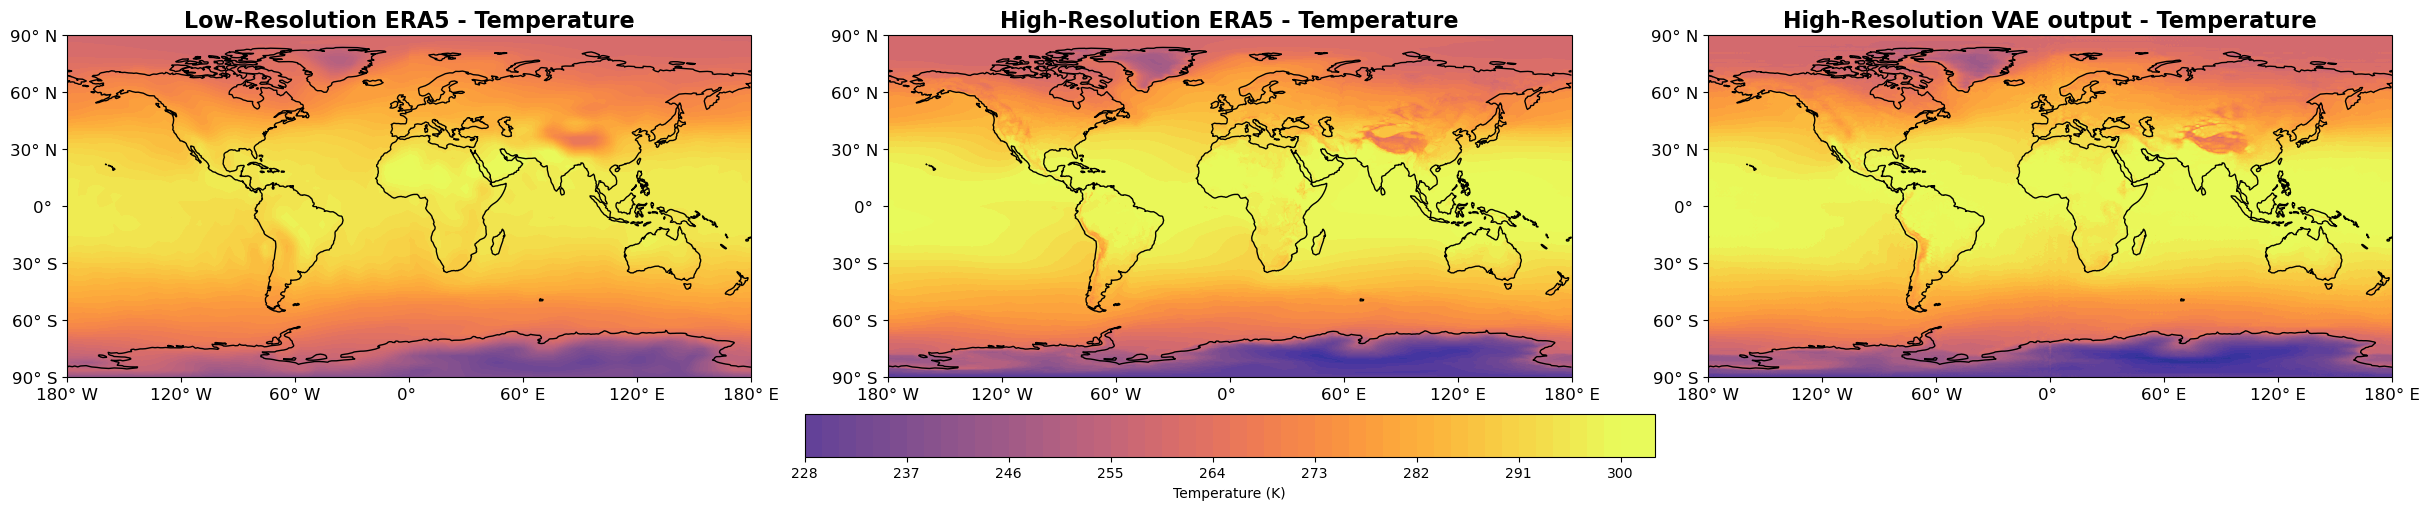

In [9]:
# Cell 2: Visualization

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as ocean

# Define coordinates
# loncoords_hres = np.linspace(0, 360, hres_stacked.shape[3])     
# latcoords_hres = np.linspace(90, -90, hres_stacked.shape[2])    
# loncoords_lres = np.linspace(0, 360, lres_stacked.shape[3])    
# latcoords_lres = np.linspace(90, -90, lres_stacked.shape[2])

loncoords_hres = np.linspace(0, 360, 1440)     
latcoords_hres = np.linspace(90, -90, 721)    
loncoords_lres = np.linspace(0, 360, 96)    
latcoords_lres = np.linspace(90, -90, 48)


# Set up the plotting parameters
projection = ccrs.PlateCarree()

# Define vmin and vmax based on combined data
vmin_temperature = min(
    hres_temperature_denorm.min(),
    output_temperature_denorm.min(),
    # lres_temperature_denorm.min(),
    # lres_interp_temperature_denorm.min(),
    # lucie_temperature.min(),
    # lucie_interp_temperature.min(),
    # lucie_zero_shot_temperature.min()

)
vmax_temperature = max(
    hres_temperature_denorm.max(),
    output_temperature_denorm.max(),
    # lres_temperature_denorm.max(),
    # lres_interp_temperature_denorm.max(),
    # lucie_temperature.max(),
    # lucie_interp_temperature.max(),
    # lucie_zero_shot_temperature.max()
)

# Plotting 'Temperature_7' channel (first sample)
sample_idx = 6

fig, axs = plt.subplots(1, 3, figsize=(30, 12), subplot_kw={'projection': projection})
# data_to_plot = [
#     (lres_temperature_denorm[sample_idx, :, :], "Low-Resolution (lres)", loncoords_lres, latcoords_lres),
#     (lucie_temperature[sample_idx, :, :], "Lucie", loncoords_lres, latcoords_lres),
#     (hres_temperature_denorm[sample_idx, :, :], "High-Resolution (hres)", loncoords_hres, latcoords_hres),
#     (output_temperature_denorm[sample_idx, :, :], "Model Output", loncoords_hres, latcoords_hres),
#     (lres_interp_temperature_denorm[sample_idx, :, :], "Low-Res Interpolated", loncoords_hres, latcoords_hres),
#     (lucie_interp_temperature[sample_idx, :, :], "Lucie Interp", loncoords_hres, latcoords_hres),
#     (lucie_zero_shot_temperature[sample_idx, :, :], "Lucie Zero Shot", loncoords_hres, latcoords_hres)

# ]
# TO CHECK DATA MATRIX
# mask_matrix = np.ones((721, 1440))
# mask_matrix[:, :240] = 0


data_to_plot = [
    (lres_denorm[0], "Low-Resolution ERA5", loncoords_lres, latcoords_lres),
    # (lucie_temperature[:, :, :].mean(0), "Lucie", loncoords_lres, latcoords_lres),
    (hres_denorm[0], "High-Resolution ERA5", loncoords_hres, latcoords_hres),
    (output_denorm[0], "High-Resolution VAE output", loncoords_hres, latcoords_hres),
    # (lres_interp_temperature_denorm[:, :, :].mean(0), "Low-Res Interpolated", loncoords_hres, latcoords_hres),
    # (lucie_interp_temperature[:, :, :].mean(0), "Lucie Interp", loncoords_hres, latcoords_hres),
    # (lucie_zero_shot_temperature[:, :, :].mean(0), "Lucie Zero Shot", loncoords_hres, latcoords_hres)

]
# data_to_plot = [
#     (lres_tp6hr_denorm[:, :, :].mean(0), "Low-Resolution ERA5", loncoords_lres, latcoords_lres),
#     # (lucie_tp6hr[:, :, :].mean(0), "Lucie", loncoords_lres, latcoords_lres),
#     (hres_tp6hr_denorm[:, :, :].mean(0)-hres_tp6hr_denorm.mean(0).min(), "High-Resolution ERA5", loncoords_hres, latcoords_hres),
#     # (lres_interp_tp6hr_denorm[:, :, :].mean(0), "Low-Res Interpolated", loncoords_hres, latcoords_hres),
#     (output_tp6hr_denorm[:, :, :].mean(0)-hres_tp6hr_denorm.mean(0).min(), "High-Resolution VAE output", loncoords_hres, latcoords_hres),
#     # (lucie_interp_tp6hr[:, :, :].mean(0), "Lucie Interp", loncoords_hres, latcoords_hres),
#     # (lucie_zero_shot_tp6hr[:, :, :].mean(0), "Lucie Zero Shot", loncoords_hres, latcoords_hres)
# ]
# Collect all images to adjust colorbar later
ims = []
# Latitude and Longitude tick marks
lat_ticks = np.arange(-90, 91, 30)  # Every 30 degrees from -90 to 90
lon_ticks = np.arange(-180, 181, 60)  # Every 60 degrees from -180 to 180

for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
    im = ax.contourf(
        loncoords, latcoords, data, vmin=200, vmax=300,
        levels=50, transform=projection, cmap=ocean.cm.thermal
    )
    ax.coastlines()
    # Set latitude and longitude ticks
    ax.set_xticks(lon_ticks, crs=projection)
    ax.set_yticks(lat_ticks, crs=projection)

    # Define latitude labels explicitly, including 90 S and 90 N
    lat_labels = [f"{abs(lat)}° {'S' if lat < 0 else 'N' if lat > 0 else ''}" for lat in lat_ticks]
    lon_labels = [f"{abs(lon)}° {'W' if lon < 0 else 'E' if lon > 0 else ''}" for lon in lon_ticks]
    
    # Set tick labels
    ax.set_xticklabels(lon_labels, fontsize=12)
    ax.set_yticklabels(lat_labels, fontsize=12)
    ax.set_title(f"{title} - Temperature", fontsize=16, fontweight="bold")
    ims.append(im)

# Add a colorbar common to all subplots
cbar = fig.colorbar(ims[0], ax=axs, orientation="horizontal", fraction=0.046, pad=0.04, )
cbar.set_label("Temperature (K)")

# plt.tight_layout()
plt.show()

### Zoomed on US (temperature)

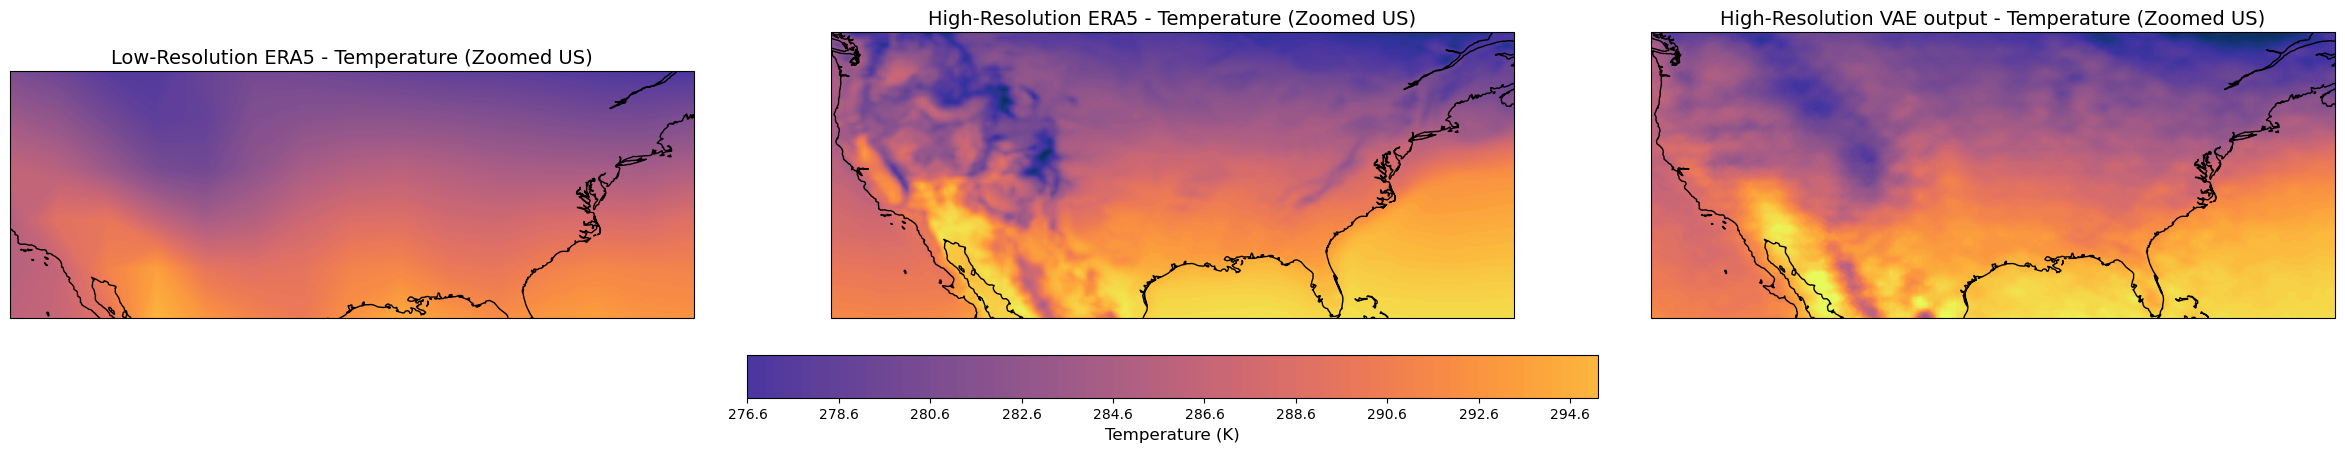

In [10]:
# Define lat/lon range for the US region
lat_min, lat_max = 25, 50  # 25°N to 50°N
# lat_min, lat_max = 30, 45  # 25°N to 50°N
# lon_min, lon_max = 60, 100  # 65°W to 125°W (converted to 0-360 longitude system)
lon_min, lon_max = 235, 295  # 65°W to 125°W (converted to 0-360 longitude system)


# Subset data to the US region
us_lat_indices_hres = (latcoords_hres >= lat_min) & (latcoords_hres <= lat_max)
us_lon_indices_hres = (loncoords_hres >= lon_min) & (loncoords_hres <= lon_max)

us_lat_indices_lres = (latcoords_lres >= lat_min) & (latcoords_lres <= lat_max)
us_lon_indices_lres = (loncoords_lres >= lon_min) & (loncoords_lres <= lon_max)

us_latcoords_hres = latcoords_hres[us_lat_indices_hres]
us_loncoords_hres = loncoords_hres[us_lon_indices_hres]

us_latcoords_lres = latcoords_lres[us_lat_indices_lres]
us_loncoords_lres = loncoords_lres[us_lon_indices_lres]

# Assume we use the first dataset from data_to_plot for demonstration
data_to_plot = [
    (lres_denorm[0][us_lat_indices_lres, :][:, us_lon_indices_lres], "Low-Resolution ERA5", us_loncoords_lres, us_latcoords_lres),
    (hres_denorm[0][us_lat_indices_hres, :][:, us_lon_indices_hres], "High-Resolution ERA5", us_loncoords_hres, us_latcoords_hres),
    (output_denorm[0][us_lat_indices_hres, :][:, us_lon_indices_hres], "High-Resolution VAE output", us_loncoords_hres, us_latcoords_hres),
]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(30, 12), subplot_kw={'projection': projection})
for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
    im = ax.contourf(
        loncoords, latcoords, data, vmin=270, vmax=300,levels=100,
        transform=projection, cmap=ocean.cm.thermal
    )
    ax.coastlines()
    # Set latitude and longitude ticks
    # ax.set_xticks(np.arange(-125, -64, 10), crs=ccrs.PlateCarree())  # Adjusted to -180 to 180 system
    # ax.set_yticks(np.arange(lat_min, lat_max+1, 5), crs=ccrs.PlateCarree())
    # ax.set_xticklabels([f"{abs(lon)}°W" for lon in np.arange(-125, -64, 10)], fontsize=10)
    # ax.set_yticklabels([f"{lat}°N" for lat in np.arange(lat_min, lat_max+1, 5)], fontsize=10)
    ax.set_title(f"{title} - Temperature (Zoomed US)", fontsize=14)
    ims.append(im)

# Add a colorbar common to all subplots
# Add a colorbar common to all subplots
cbar = fig.colorbar(
    axs[0].collections[0],  # Use the first plot's pcolormesh collection
    ax=axs,
    orientation="horizontal",
    fraction=0.046,
    pad=0.04,
)
cbar.set_label("Temperature (K)", fontsize=12)


# plt.tight_layout()
plt.show()


### This is the code to subset US using Haiwen's lats and lons:

In [77]:
bobool = output_denorm[0][us_lat_indices_hres, :][:, us_lon_indices_hres]
circular_padding = torch.nn.CircularPad2d((3, 4, 3, 4))
bobool = circular_padding(torch.tensor(bobool).unsqueeze(0).unsqueeze(0))
print(bobool.shape)


torch.Size([1, 1, 152, 296])


In [79]:
296/8


37.0

(10, 20)
(145, 289)
(145, 289)


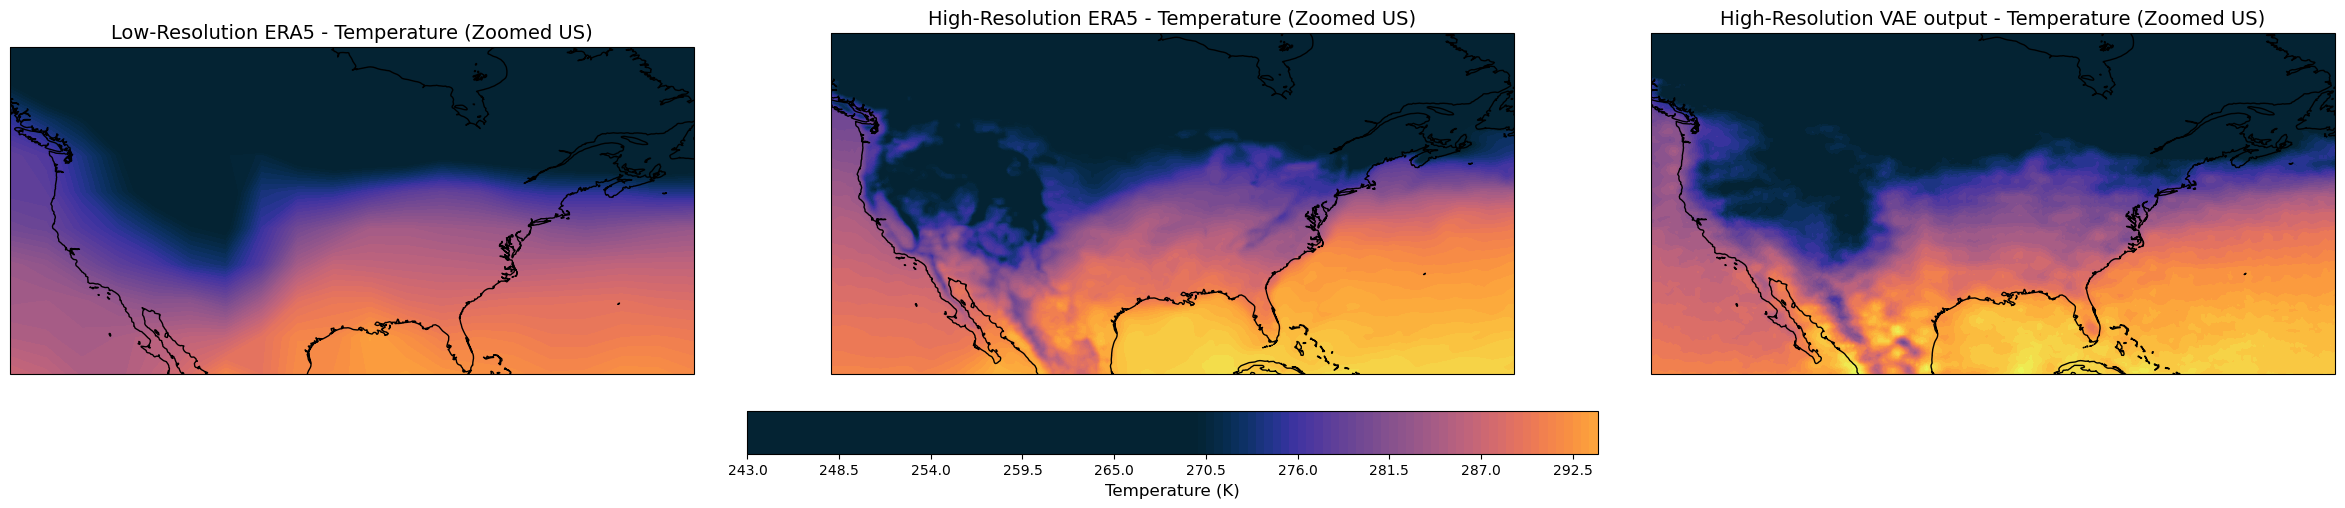

In [75]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as ocean

projection = ccrs.PlateCarree()

# Define lat/lon range for the US region
lat_min, lat_max = 25, 50  # 25°N to 50°N
# lat_min, lat_max = 30, 45  # 25°N to 50°N
# lon_min, lon_max = 60, 100  # 65°W to 125°W (converted to 0-360 longitude system)
lon_min, lon_max = 235, 295  # 65°W to 125°W (converted to 0-360 longitude system)


loncoords_hres = np.linspace(0, 360, 1440)     
latcoords_hres = np.linspace(90, -90, 721)    
loncoords_lres = np.linspace(0, 360, 96)    
latcoords_lres = np.linspace(90, -90, 48)

# Subset data to the US region
us_lat_indices_hres = range(720 - 1 - 590, 720 - 1 - 446 + 1)  # Flipped latitude indices
us_lon_indices_hres = range(930, 1218 + 1)  # Longitude indices remain unchanged

# Define the latitude and longitude index ranges for low-resolution (lres) data
us_lat_indices_lres = range(48 - 1 - 39, 48 - 1 - 30 + 1)  # Flipped latitude indices
us_lon_indices_lres = range(61, 80 + 1)  # Longitude indices remain unchanged

us_latcoords_hres = latcoords_hres[us_lat_indices_hres]
us_loncoords_hres = loncoords_hres[us_lon_indices_hres]

us_latcoords_lres = latcoords_lres[us_lat_indices_lres]
us_loncoords_lres = loncoords_lres[us_lon_indices_lres]

# Assume we use the first dataset from data_to_plot for demonstration
data_to_plot = [
    (lres_denorm[0][us_lat_indices_lres, :][:, us_lon_indices_lres], "Low-Resolution ERA5", us_loncoords_lres, us_latcoords_lres),
    (hres_denorm[0][us_lat_indices_hres, :][:, us_lon_indices_hres], "High-Resolution ERA5", us_loncoords_hres, us_latcoords_hres),
    (output_denorm[0][us_lat_indices_hres, :][:, us_lon_indices_hres], "High-Resolution VAE output", us_loncoords_hres, us_latcoords_hres),
]
ims = []
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(30, 12), subplot_kw={'projection': projection})
for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
    print(data.shape)

    im = ax.contourf(
        loncoords, latcoords, data, vmin=270, vmax=300,levels=100,
        transform=projection, cmap=ocean.cm.thermal
    )
    ax.coastlines()
    # Set latitude and longitude ticks
    # ax.set_xticks(np.arange(-125, -64, 10), crs=ccrs.PlateCarree())  # Adjusted to -180 to 180 system
    # ax.set_yticks(np.arange(lat_min, lat_max+1, 5), crs=ccrs.PlateCarree())
    # ax.set_xticklabels([f"{abs(lon)}°W" for lon in np.arange(-125, -64, 10)], fontsize=10)
    # ax.set_yticklabels([f"{lat}°N" for lat in np.arange(lat_min, lat_max+1, 5)], fontsize=10)
    ax.set_title(f"{title} - Temperature (Zoomed US)", fontsize=14)
    ims.append(im)


cbar = fig.colorbar(
    axs[0].collections[0],  # Use the first plot's pcolormesh collection
    ax=axs,
    orientation="horizontal",
    fraction=0.046,
    pad=0.04,
)
cbar.set_label("Temperature (K)", fontsize=12)

plt.show()


## Percip visualization

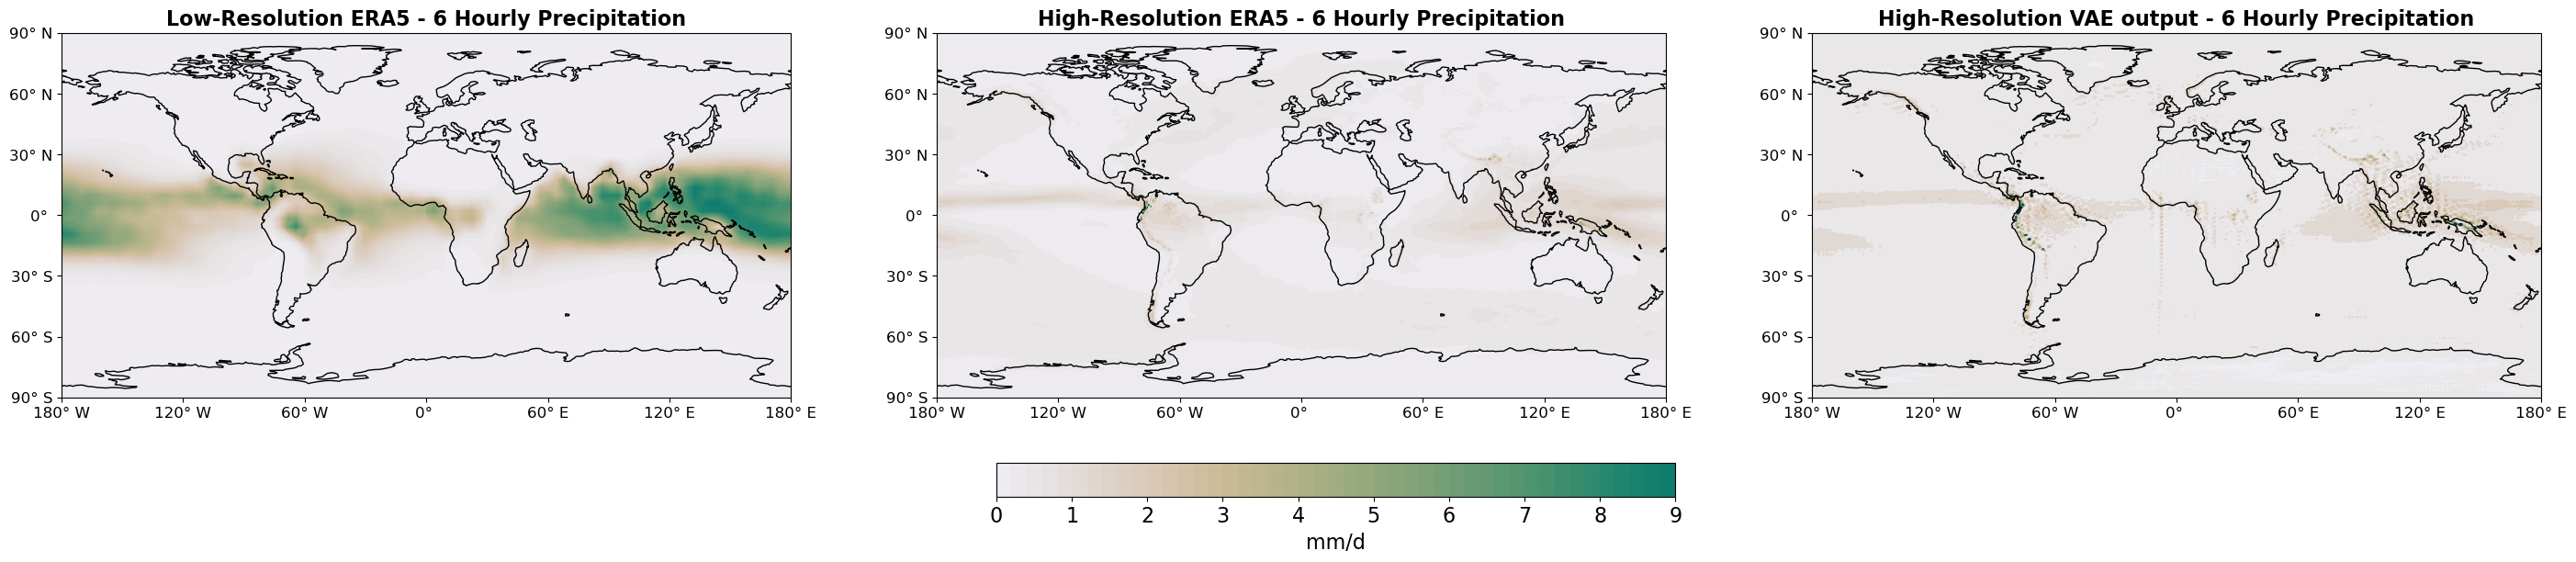

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as ocean

# Denofine coordinates
# loncoords_hres = np.linspace(0, 360, hres_stacked.shape[3])     
# latcoords_hres = np.linspace(90, -90, hres_stacked.shape[2])    

# loncoords_lres = np.linspace(0, 360, lres_stacked.shape[3])    
# latcoords_lres = np.linspace(90, -90, lres_stacked.shape[2])


loncoords_hres = np.linspace(0, 360, 1440)     
latcoords_hres = np.linspace(90, -90, 721)    
loncoords_lres = np.linspace(0, 360, 96)    
latcoords_lres = np.linspace(90, -90, 48)



# Set up the plotting parameters
projection = ccrs.PlateCarree()

# Define vmin and vmax based on combined data
vmin_tp6hr = min(
    hres_tp6hr_denorm.min(),
    output_tp6hr_denorm.min(),
    lres_tp6hr_denorm.min(),
    lres_interp_tp6hr_denorm.min(),
    lucie_tp6hr.min(),
    lucie_interp_tp6hr.min(),
    lucie_zero_shot_tp6hr.min()
)
vmax_tp6hr = max(
    hres_tp6hr_denorm.max(),
    output_tp6hr_denorm.max(),
    lres_tp6hr_denorm.max(),
    lres_interp_tp6hr_denorm.max(),
    lucie_tp6hr.max(),
    lucie_interp_tp6hr.max(),
    lucie_zero_shot_tp6hr.max()
)

# Plotting 'tp6hr' channel (first sample)
sample_idx = 5

fig, axs = plt.subplots(1, 3, figsize=(30, 12), subplot_kw={'projection': projection})
# data_to_plot = [
#     (lres_tp6hr_denorm[sample_idx, :, :], "Low-Resolution (lres)", loncoords_lres, latcoords_lres),
#     (lucie_tp6hr[sample_idx, :, :], "Lucie", loncoords_lres, latcoords_lres),
#     (hres_tp6hr_denorm[sample_idx, :, :], "High-Resolution (hres)", loncoords_hres, latcoords_hres),
#     (lres_interp_tp6hr_denorm[sample_idx, :, :], "Low-Res Interpolated", loncoords_hres, latcoords_hres),
#     (output_tp6hr_denorm[sample_idx, :, :], "Model Output", loncoords_hres, latcoords_hres),
#     (lucie_interp_tp6hr[sample_idx, :, :], "Lucie Interp", loncoords_hres, latcoords_hres),
#     (lucie_zero_shot_tp6hr[sample_idx, :, :], "Lucie Zero Shot", loncoords_hres, latcoords_hres)
# ]
data_to_plot = [
    (lres_denorm[1]*1000, "Low-Resolution ERA5", loncoords_lres, latcoords_lres),
    # (lucie_tp6hr[:, :, :].mean(0), "Lucie", loncoords_lres, latcoords_lres),
    ((hres_denorm[1]-hres_denorm[1].min())*1000, "High-Resolution ERA5", loncoords_hres, latcoords_hres),
    # (lres_interp_tp6hr_denorm[:, :, :].mean(0), "Low-Res Interpolated", loncoords_hres, latcoords_hres),
    ((output_denorm[1]-hres_denorm[1].min())*1000, "High-Resolution VAE output", loncoords_hres, latcoords_hres),
    # (lucie_interp_tp6hr[:, :, :].mean(0), "Lucie Interp", loncoords_hres, latcoords_hres),
    # (lucie_zero_shot_tp6hr[:, :, :].mean(0), "Lucie Zero Shot", loncoords_hres, latcoords_hres)
]

# Collect all images to adjust colorbar later
ims = []
# Latitude and Longitude tick marks
lat_ticks = np.arange(-90, 91, 30)  # Every 30 degrees from -90 to 90
lon_ticks = np.arange(-180, 181, 60)  # Every 60 degrees from -180 to 180

for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
    im = ax.contourf(
        loncoords, latcoords, data, vmin=0, vmax=15,
        levels=50, transform=projection, cmap=ocean.cm.rain
    )
    ax.coastlines()
    # Set latitude and longitude ticks
    ax.set_xticks(lon_ticks, crs=projection)
    ax.set_yticks(lat_ticks, crs=projection)
    # Define latitude labels explicitly, including 90 S and 90 N
    lat_labels = [f"{abs(lat)}° {'S' if lat < 0 else 'N' if lat > 0 else ''}" for lat in lat_ticks]
    lon_labels = [f"{abs(lon)}° {'W' if lon < 0 else 'E' if lon > 0 else ''}" for lon in lon_ticks]
    # Set tick labels
    ax.set_xticklabels(lon_labels, fontsize=12)
    ax.set_yticklabels(lat_labels, fontsize=12)
    ax.set_title(f"{title} - 6 Hourly Precipitation", fontsize=16, fontweight="bold")
    ims.append(im)

# Add a colorbar common to all subplots
cbar = fig.colorbar(
    ims[0],
    ax=axs,
    orientation="horizontal",
    fraction=0.04,  # Adjust size
    pad=0.1,        # Adjust distance
    extend="both"
)
cbar.set_label("mm/d", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Adjust subplot spacing to avoid overlap
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.2, wspace=0.2, hspace=0.2)

plt.show()

### Percip visualization (Zoomed on US)

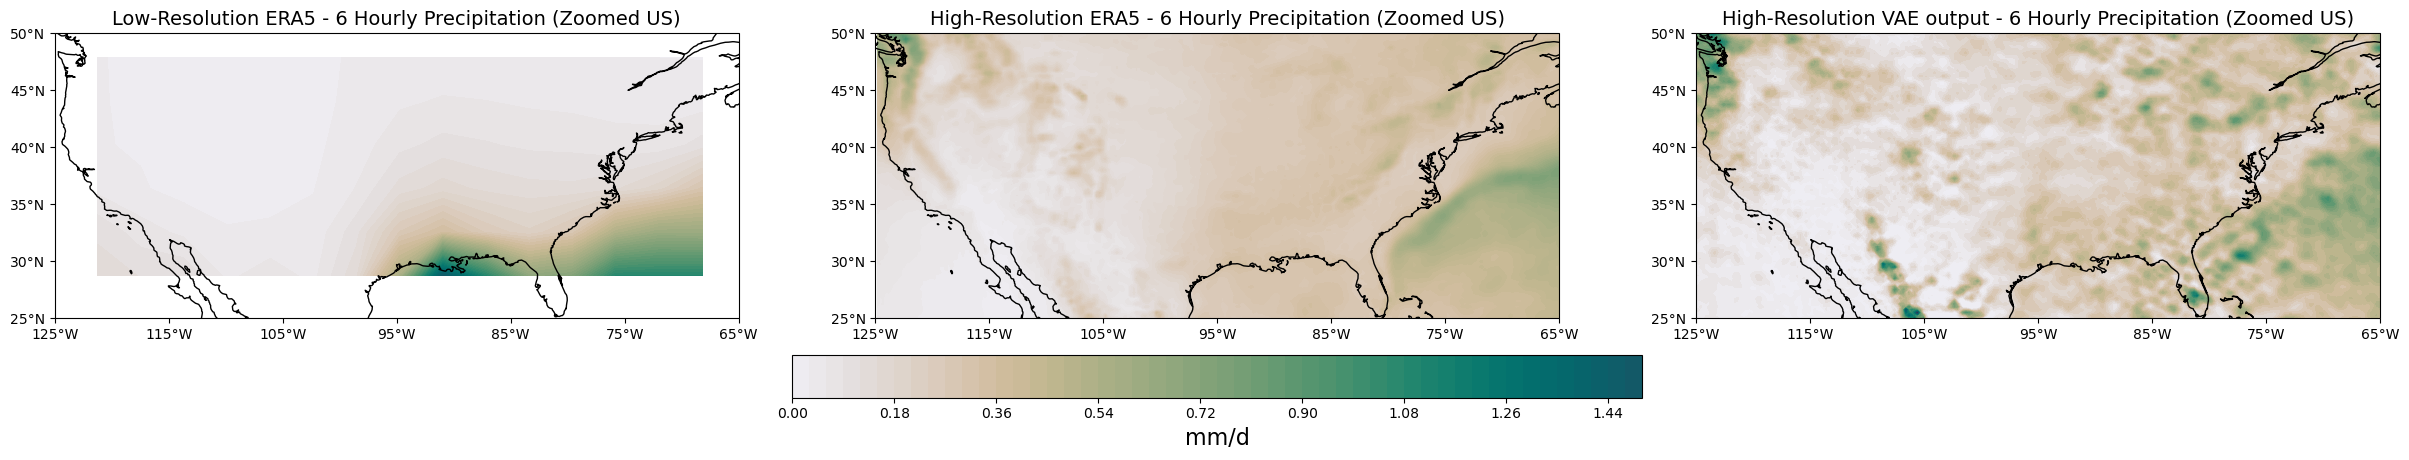

In [12]:
# Define lat/lon range for the US region
lat_min, lat_max = 25, 50  # 25°N to 50°N
lon_min, lon_max = 235, 295  # 65°W to 125°W (converted to 0-360 longitude system)


# Subset data to the US region
us_lat_indices_hres = (latcoords_hres >= lat_min) & (latcoords_hres <= lat_max)
us_lon_indices_hres = (loncoords_hres >= lon_min) & (loncoords_hres <= lon_max)

us_lat_indices_lres = (latcoords_lres >= lat_min) & (latcoords_lres <= lat_max)
us_lon_indices_lres = (loncoords_lres >= lon_min) & (loncoords_lres <= lon_max)

us_latcoords_hres = latcoords_hres[us_lat_indices_hres]
us_loncoords_hres = loncoords_hres[us_lon_indices_hres]

us_latcoords_lres = latcoords_lres[us_lat_indices_lres]
us_loncoords_lres = loncoords_lres[us_lon_indices_lres]

# Assume we use the first dataset from data_to_plot for demonstration
data_to_plot = [
    ((lres_denorm[1]*1000)[us_lat_indices_lres, :][:, us_lon_indices_lres], "Low-Resolution ERA5", us_loncoords_lres, us_latcoords_lres),
    (((hres_denorm[1]-hres_denorm[1].min())*1000)[us_lat_indices_hres, :][:, us_lon_indices_hres], "High-Resolution ERA5", us_loncoords_hres, us_latcoords_hres),
    (((output_denorm[1]-hres_denorm[1].min())*1000)[us_lat_indices_hres, :][:, us_lon_indices_hres], "High-Resolution VAE output", us_loncoords_hres, us_latcoords_hres),
]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(30, 12), subplot_kw={'projection': projection})
for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
    im = ax.contourf(
        loncoords, latcoords, data, vmin=0, vmax=2,
        levels=50, transform=projection, cmap=ocean.cm.rain
    )
    ax.coastlines()
    # Set latitude and longitude ticks
    ax.set_xticks(np.arange(-125, -64, 10), crs=ccrs.PlateCarree())  # Adjusted to -180 to 180 system
    ax.set_yticks(np.arange(lat_min, lat_max+1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([f"{abs(lon)}°W" for lon in np.arange(-125, -64, 10)], fontsize=10)
    ax.set_yticklabels([f"{lat}°N" for lat in np.arange(lat_min, lat_max+1, 5)], fontsize=10)
    ax.set_title(f"{title} - 6 Hourly Precipitation (Zoomed US)", fontsize=14)
    ims.append(im)

# Add a colorbar common to all subplots
# Add a colorbar common to all subplots
cbar = fig.colorbar(
    axs[0].collections[0],  # Use the first plot's pcolormesh collection
    ax=axs,
    orientation="horizontal",
    fraction=0.046,
    pad=0.04,
)
cbar.set_label("mm/d", fontsize=16)


# plt.tight_layout()
plt.show()


# Metrics Computation

## Calculate the metrics

In [13]:
import torch
# Initialize dictionaries to store results for each metric
metrics_output_vs_hres = {}
metrics_lres_interp_vs_hres = {}
metrics_lucie_vs_hres = {}

# Define a helper function to compute all metrics for given tensors
def compute_metrics(pred, target):
    results = {
        "Latitude Weighted RMSE": latitude_weighted_rmse(pred, target),
        "SSIM": ssim(pred.numpy(), target.numpy(), data_range=(target.max() - target.min()).numpy()),
        "Spectrum RMSE": spectrum_rmse(pred, target),
        "PSNR": psnr(pred, target),
        "MAE": mae(pred, target),
        "max_error": max_error(pred, target)
    }
    return results

# Iterate over both channels
for channel in range(2):  # Assuming you want metrics for the first two channels only
    # Compute metrics between output and hres
    metrics_output_vs_hres[f"Channel {channel}"] = compute_metrics(torch.tensor(output_denorm[channel]), torch.tensor(hres_denorm[channel]))
    
    # Compute metrics between lres_interp and hres
    metrics_lres_interp_vs_hres[f"Channel {channel}"] = compute_metrics(torch.tensor(lres_interp_denorm[channel]), torch.tensor(hres_denorm[channel]))

    # Compute metrics between lucie and hres
    metrics_lucie_vs_hres[f"Channel {channel}"] = compute_metrics(torch.tensor(lucie_zero_shot_denorm[channel]), torch.tensor(hres_denorm[channel]))

# Print the results for each channel
print("Metrics for Output vs HRES:")
for channel, results in metrics_output_vs_hres.items():
    print(f"{channel}:")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

print("\nMetrics for LRES_INTERP vs HRES:")
for channel, results in metrics_lres_interp_vs_hres.items():
    print(f"{channel}:")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

print("\nMetrics for LUCIE vs HRES:")
for channel, results in metrics_lucie_vs_hres.items():
    print(f"{channel}:")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

Metrics for Output vs HRES:
Channel 0:
  Latitude Weighted RMSE: 0.9551
  SSIM: 0.9619
  Spectrum RMSE: 0.9034
  PSNR: 49.7900
  MAE: 0.6877
  max_error: 17.7256
Channel 1:
  Latitude Weighted RMSE: 0.0003
  SSIM: 0.9407
  Spectrum RMSE: 0.0024
  PSNR: 35.7057
  MAE: 0.0001
  max_error: 0.0328

Metrics for LRES_INTERP vs HRES:
Channel 0:
  Latitude Weighted RMSE: 3.7849
  SSIM: 0.9491
  Spectrum RMSE: 17.5569
  PSNR: 36.4574
  MAE: 3.4250
  max_error: 22.4082
Channel 1:
  Latitude Weighted RMSE: 0.0018
  SSIM: 0.2503
  Spectrum RMSE: 0.0003
  PSNR: 18.6140
  MAE: 0.0014
  max_error: 0.0123

Metrics for LUCIE vs HRES:
Channel 0:
  Latitude Weighted RMSE: 1.3436
  SSIM: 0.9592
  Spectrum RMSE: 0.9826
  PSNR: 46.6615
  MAE: 1.0525
  max_error: 17.9208
Channel 1:
  Latitude Weighted RMSE: 0.0011
  SSIM: 0.3716
  Spectrum RMSE: 0.0021
  PSNR: 22.5329
  MAE: 0.0010
  max_error: 0.0673


### Make Movie

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as ocean
import imageio
import gc

# Define coordinates
loncoords_hres = np.linspace(0, 360, hres_stacked.shape[3])     
latcoords_hres = np.linspace(90, -90, hres_stacked.shape[2])    
loncoords_lres = np.linspace(0, 360, lres_stacked.shape[3])    
latcoords_lres = np.linspace(90, -90, lres_stacked.shape[2])

# Set up the plotting parameters
projection = ccrs.PlateCarree()

# Define vmin and vmax based on combined data
vmin_tp6hr = min(
    hres_tp6hr_denorm.min(),
    output_tp6hr_denorm.min(),
    lres_tp6hr_denorm.min(),
    lres_interp_tp6hr_denorm.min(),
    lucie_tp6hr.min(),
    lucie_interp_tp6hr.min(),
    lucie_zero_shot_tp6hr.min()
)
vmax_tp6hr = max(
    hres_tp6hr_denorm.max(),
    output_tp6hr_denorm.max(),
    lres_tp6hr_denorm.max(),
    lres_interp_tp6hr_denorm.max(),
    lucie_tp6hr.max(),
    lucie_interp_tp6hr.max(),
    lucie_zero_shot_tp6hr.max()
)

# Determine how many samples you want to loop over for the movie
# For demonstration, let's assume you want to loop over the first 20 samples:
num_samples = 20

# Set up the GIF writer
output_gif = "percip_movie.gif"
fps = 5
writer = imageio.get_writer(output_gif, fps=fps, format="GIF")

for sample_idx in range(num_samples):
    # Create a new figure and axes for each frame
    fig, axs = plt.subplots(1, 7, figsize=(20, 5), subplot_kw={'projection': projection})

    data_to_plot = [
        (lres_tp6hr_denorm[sample_idx, :, :], "Low-Resolution (lres)", loncoords_lres, latcoords_lres),
        (lucie_tp6hr[sample_idx, :, :], "Lucie", loncoords_lres, latcoords_lres),
        (hres_tp6hr_denorm[sample_idx, :, :], "High-Resolution (hres)", loncoords_hres, latcoords_hres),
        (lres_interp_tp6hr_denorm[sample_idx, :, :], "Low-Res Interpolated", loncoords_hres, latcoords_hres),
        (output_tp6hr_denorm[sample_idx, :, :], "Model Output", loncoords_hres, latcoords_hres),
        (lucie_interp_tp6hr[sample_idx, :, :], "Lucie Interp", loncoords_hres, latcoords_hres),
        (lucie_zero_shot_tp6hr[sample_idx, :, :], "Lucie Zero Shot", loncoords_hres, latcoords_hres)
    ]

    ims = []
    for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
        im = ax.pcolormesh(
            loncoords, latcoords, data, vmin=vmin_tp6hr, vmax=0.01,
            transform=projection, cmap=ocean.cm.rain, shading="auto"
        )
        ax.coastlines()
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
        ax.set_yticks(np.linspace(-90, 90, 5), crs=projection)
        ax.set_title(f"{title} - tp6hr (sample={sample_idx})", fontsize=10, fontweight="bold")
        ims.append(im)

    # Add a colorbar common to all subplots
    cbar = fig.colorbar(ims[0], ax=axs, orientation="horizontal", fraction=0.046, pad=0.04, extend="both")
    cbar.set_label("mm/d", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)

    # Draw the figure canvas so we can capture it as an image
    fig.canvas.draw()

    # Convert to a numpy array for the GIF
    image = np.array(fig.canvas.renderer.buffer_rgba())

    # Append the frame to the GIF
    writer.append_data(image)

    # Clear the figure from memory
    plt.close(fig)
    gc.collect()

writer.close()

## Calculate Power Spectrum and Std

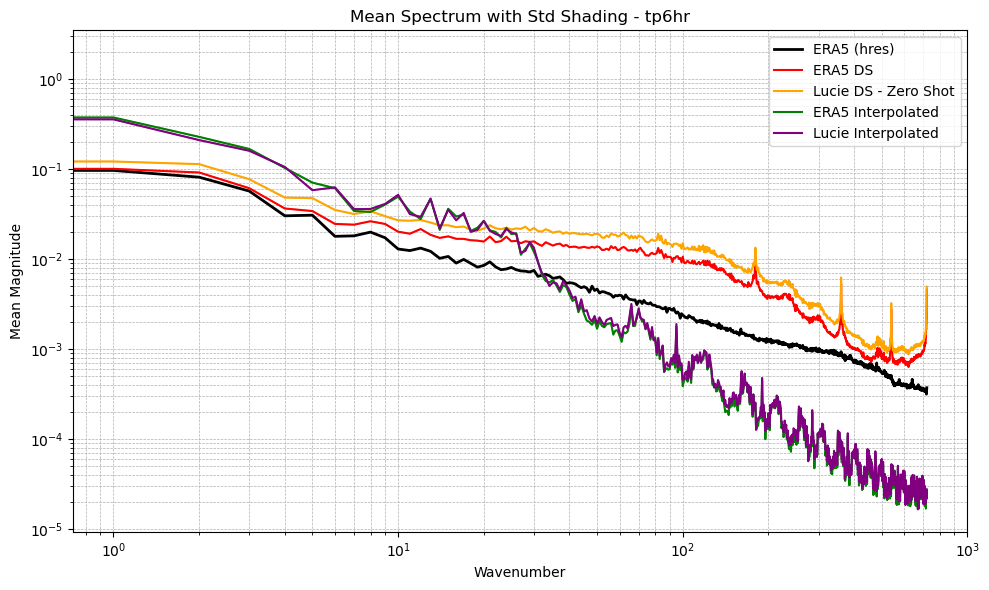

In [14]:
# Compute the spectra
# hres_spectrum = compute_spectrum_torch(hres_tp6hr_denorm)
# output_spectrum = compute_spectrum_torch(output_tp6hr_denorm)
# lres_interp_spectrum = compute_spectrum_torch(lres_interp_tp6hr_denorm)
# lucie_interp_spectrum = compute_spectrum_torch(lucie_interp_tp6hr)
# lucie_zero_shot_spectrum = compute_spectrum_torch(lucie_zero_shot_tp6hr)

hres_spectrum = compute_spectrum_torch(torch.tensor(hres_denorm[1]).unsqueeze(0))
output_spectrum = compute_spectrum_torch(torch.tensor(output_denorm[1]).unsqueeze(0))
lres_interp_spectrum = compute_spectrum_torch(torch.tensor(lres_interp_denorm[1]).unsqueeze(0))
lucie_interp_spectrum = compute_spectrum_torch(torch.tensor(lucie_interp_denorm[1]).unsqueeze(0))
lucie_zero_shot_spectrum = compute_spectrum_torch(torch.tensor(lucie_zero_shot_denorm[1]).unsqueeze(0))



hres_spectrum_mean = hres_spectrum.mean(axis=1).mean(axis=0)
hres_spectrum_std = hres_spectrum.mean(axis=1).std(axis=0)

output_spectrum_mean = output_spectrum.mean(axis=1).mean(axis=0)
output_spectrum_std = output_spectrum.mean(axis=1).std(axis=0)

lres_interp_spectrum_mean = lres_interp_spectrum.mean(axis=1).mean(axis=0)
lres_interp_spectrum_std = lres_interp_spectrum.mean(axis=1).std(axis=0)

lucie_interp_spectrum_mean = lucie_interp_spectrum.mean(axis=1).mean(axis=0)
lucie_interp_spectrum_std = lucie_interp_spectrum.mean(axis=1).std(axis=0)

lucie_zero_shot_spectrum_mean = lucie_zero_shot_spectrum.mean(axis=1).mean(axis=0)
lucie_zero_shot_spectrum_std = lucie_zero_shot_spectrum.mean(axis=1).std(axis=0)

# Wavenumbers
longitude_points = hres_denorm[1].shape[-1]
wavenumbers = np.arange(0, longitude_points // 2 + 1)

# Plotting the spectra
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting High-Resolution Spectrum
plt.loglog(wavenumbers, hres_spectrum_mean, label="ERA5 (hres)", color="black", linewidth=2)
plt.fill_between(wavenumbers, hres_spectrum_mean - hres_spectrum_std, hres_spectrum_mean + hres_spectrum_std, color="blue", alpha=0.3)

# Plotting Model Output Spectrum
plt.loglog(wavenumbers, output_spectrum_mean, label="ERA5 DS", color="red")
plt.fill_between(wavenumbers, output_spectrum_mean - output_spectrum_std, output_spectrum_mean + output_spectrum_std, color="red", alpha=0.3)

# Plotting Lucie Zero Shot Spectrum
plt.loglog(wavenumbers, lucie_zero_shot_spectrum_mean, label="Lucie DS - Zero Shot", color="orange")
plt.fill_between(wavenumbers, lucie_zero_shot_spectrum_mean - lucie_zero_shot_spectrum_std, lucie_zero_shot_spectrum_mean + lucie_zero_shot_spectrum_std, color="orange", alpha=0.3)

# Plotting Low-Res Interpolated Spectrum
plt.loglog(wavenumbers, lres_interp_spectrum_mean, label="ERA5 Interpolated", color="green")
plt.fill_between(wavenumbers, lres_interp_spectrum_mean - lres_interp_spectrum_std, lres_interp_spectrum_mean + lres_interp_spectrum_std, color="green", alpha=0.3)

# Plotting Lucie Interpolated Spectrum
plt.loglog(wavenumbers, lucie_interp_spectrum_mean, label="Lucie Interpolated", color="purple")
plt.fill_between(wavenumbers, lucie_interp_spectrum_mean - lucie_interp_spectrum_std, lucie_interp_spectrum_mean + lucie_interp_spectrum_std, color="purple", alpha=0.3)


plt.title("Mean Spectrum with Std Shading - tp6hr")
plt.xlabel("Wavenumber")
plt.ylabel("Mean Magnitude")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

(721,)


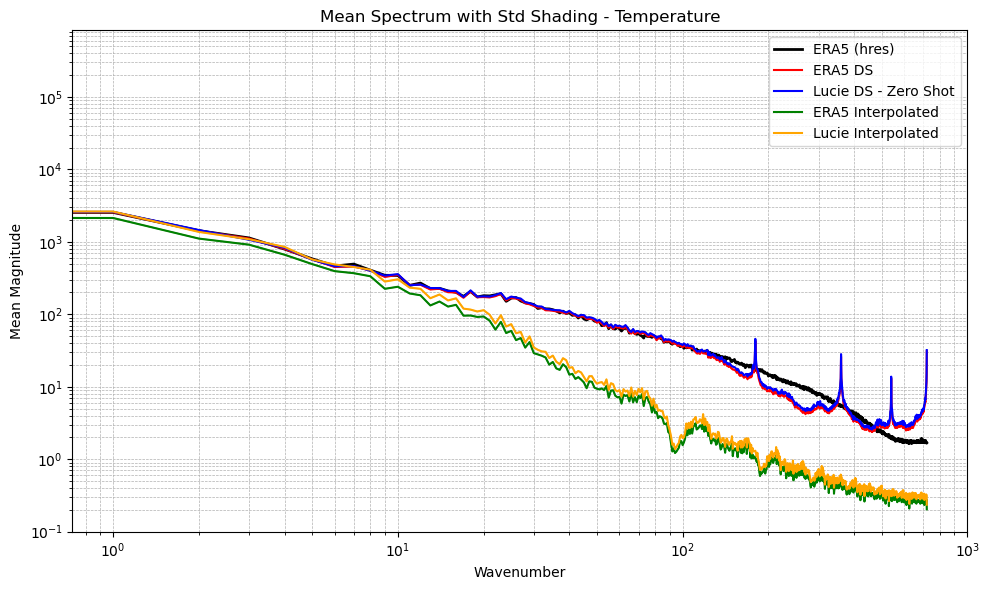

In [15]:
# Compute the spectra
# hres_spectrum = compute_spectrum_torch(hres_temperature_denorm)
# output_spectrum = compute_spectrum_torch(output_temperature_denorm)
# lres_interp_spectrum = compute_spectrum_torch(lres_interp_temperature_denorm)
# lucie_spectrum = compute_spectrum_torch(lucie_temperature)
# lucie_interp_spectrum = compute_spectrum_torch(lucie_interp_temperature)
# lucie_zero_shot_spectrum = compute_spectrum_torch(lucie_zero_shot_temperature)

hres_spectrum = compute_spectrum_torch(torch.tensor(hres_denorm[0]).unsqueeze(0))
output_spectrum = compute_spectrum_torch(torch.tensor(output_denorm[0]).unsqueeze(0))
lres_interp_spectrum = compute_spectrum_torch(torch.tensor(lres_interp_denorm[0]).unsqueeze(0))
lucie_spectrum = compute_spectrum_torch(torch.tensor(lucie_denorm[0]).unsqueeze(0))
lucie_interp_spectrum = compute_spectrum_torch(torch.tensor(lucie_interp_denorm[0]).unsqueeze(0))
lucie_zero_shot_spectrum = compute_spectrum_torch(torch.tensor(lucie_zero_shot_denorm[0]).unsqueeze(0))
                                                  
hres_spectrum_mean = hres_spectrum.mean(axis=1).mean(axis=0)
hres_spectrum_std = hres_spectrum.mean(axis=1).std(axis=0)

output_spectrum_mean = output_spectrum.mean(axis=1).mean(axis=0)
output_spectrum_std = output_spectrum.mean(axis=1).std(axis=0)

lres_interp_spectrum_mean = lres_interp_spectrum.mean(axis=1).mean(axis=0)
lres_interp_spectrum_std = lres_interp_spectrum.mean(axis=1).std(axis=0)

lucie_spectrum_mean = lucie_spectrum.mean(axis=1).mean(axis=0)
lucie_spectrum_std = lucie_spectrum.mean(axis=1).std(axis=0)

lucie_interp_spectrum_mean = lucie_interp_spectrum.mean(axis=1).mean(axis=0)
lucie_interp_spectrum_std = lucie_interp_spectrum.mean(axis=1).std(axis=0)

lucie_zero_shot_spectrum_mean = lucie_zero_shot_spectrum.mean(axis=1).mean(axis=0)
lucie_zero_shot_spectrum_std = lucie_zero_shot_spectrum.mean(axis=1).std(axis=0)

# Wavenumbers
longitude_points = hres_denorm.shape[-1]
wavenumbers = np.arange(0, longitude_points // 2 + 1)

print(wavenumbers.shape)

# Plotting the spectra
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting High-Resolution Spectrum
plt.loglog(wavenumbers, hres_spectrum_mean, label="ERA5 (hres)", color="black", linewidth=2)
plt.fill_between(wavenumbers, hres_spectrum_mean - hres_spectrum_std, hres_spectrum_mean + hres_spectrum_std, color="blue", alpha=0.3)

# Plotting Model Output Spectrum
plt.loglog(wavenumbers, output_spectrum_mean, label="ERA5 DS", color="red")
plt.fill_between(wavenumbers, output_spectrum_mean - output_spectrum_std, output_spectrum_mean + output_spectrum_std, color="red", alpha=0.3)

# Plotting Lucie Zero Shot Spectrum
plt.loglog(wavenumbers, lucie_zero_shot_spectrum_mean, label="Lucie DS - Zero Shot", color="blue")
plt.fill_between(wavenumbers, lucie_zero_shot_spectrum_mean - lucie_zero_shot_spectrum_std, lucie_zero_shot_spectrum_mean + lucie_zero_shot_spectrum_std, color="black", alpha=0.3)

# Plotting Low-Res Interpolated Spectrum
plt.loglog(wavenumbers, lres_interp_spectrum_mean, label="ERA5 Interpolated", color="green")
plt.fill_between(wavenumbers, lres_interp_spectrum_mean - lres_interp_spectrum_std, lres_interp_spectrum_mean + lres_interp_spectrum_std, color="green", alpha=0.3)

# Plotting Lucie Spectrum
# plt.loglog(wavenumbers, lucie_spectrum_mean, label="Lucie", color="purple")
# plt.fill_between(wavenumbers, lucie_spectrum_mean - lucie_spectrum_std, lucie_spectrum_mean + lucie_spectrum_std, color="purple", alpha=0.3)

# Plotting Lucie Interpolated Spectrum
plt.loglog(wavenumbers, lucie_interp_spectrum_mean, label="Lucie Interpolated", color="orange")
plt.fill_between(wavenumbers, lucie_interp_spectrum_mean - lucie_interp_spectrum_std, lucie_interp_spectrum_mean + lucie_interp_spectrum_std, color="orange", alpha=0.3)


plt.title("Mean Spectrum with Std Shading - Temperature")
plt.xlabel("Wavenumber")
plt.ylabel("Mean Magnitude")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# Diff model

In [42]:
import numpy as np
import os

# Define the path and initialize storage variables
task_name = "vae_concat_LUCIE_v1"
path = f"/media/volume/moein-storage-1/lucie/results/{task_name}/samples_ddpm"

# Example shape of one batch (use the shape from one file for initialization)
example_file = os.path.join(path, "ldm_1.npz")
with np.load(example_file) as data:
    shape_hres = data['hres'].shape              # Shape: [batch_size, channels, 721, 1440]
    shape_output = data['output'].shape          # Shape: [batch_size, channels, 721, 1440]
    

sum_hres = np.zeros(shape_hres[1:], dtype=np.float32)  # Exclude batch dimension
sum_output = np.zeros(shape_output[1:], dtype=np.float32)


counter_hres = 0
counter_output = 0


for idx in range(1, 20):
    with np.load(os.path.join(path, f'ldm_{idx}.npz')) as data:
        sum_hres += data['hres'].sum(axis=0)  # Sum over batch dimension
        counter_hres += data['hres'].shape[0]

        sum_output += data['output'].sum(axis=0)
        counter_output += data['output'].shape[0]
        
mean_hres = sum_hres / counter_hres
mean_output = sum_output / counter_output

# Load denormalization statistics
lr_stats = np.load("/media/volume/moein-storage-1/lucie/stats_2000_2003_lr.npz", allow_pickle=True)
hr_stats = np.load("/media/volume/moein-storage-1/lucie/stats_2000_2003_hr.npz", allow_pickle=True)

# Extract mean and std for each channel
temperature_mean_hr = hr_stats['2m_temperature'].item()['mean']
temperature_std_hr = hr_stats['2m_temperature'].item()['std']
precip_mean_hr = hr_stats['tp6hr'].item()['mean']
precip_std_hr = hr_stats['tp6hr'].item()['std']

temperature_mean_lr = lr_stats['Temperature_7'].item()['mean']
temperature_std_lr = lr_stats['Temperature_7'].item()['std']
precip_mean_lr = lr_stats['tp6hr'].item()['mean']
precip_std_lr = lr_stats['tp6hr'].item()['std']


hres_temperature_denorm = mean_hres[0, :, :] * temperature_std_hr + temperature_mean_hr
output_temperature_denorm = mean_output[0, :, :] * temperature_std_hr + temperature_mean_hr


hres_tp6hr_denorm = np.exp(mean_hres[1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6
output_tp6hr_denorm = np.exp(mean_output[1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6  


# Stack channel 0 and channel 1
hres_denorm = np.stack([hres_temperature_denorm, hres_tp6hr_denorm], axis=0)
output_denorm = np.stack([output_temperature_denorm, output_tp6hr_denorm], axis=0)



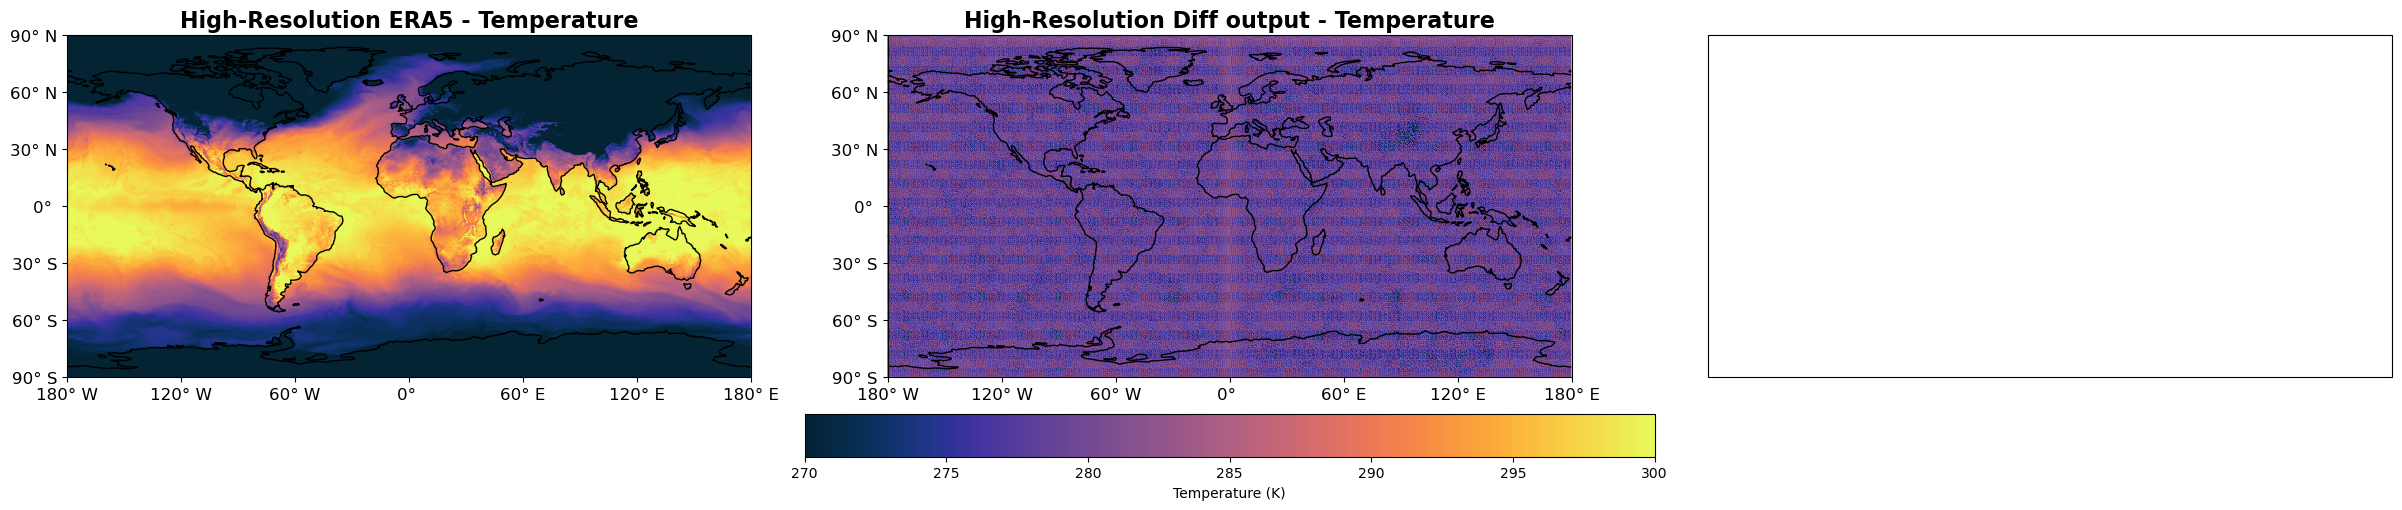

In [46]:
# Cell 2: Visualization

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as ocean

# Define coordinates
loncoords_hres = np.linspace(0, 360, 1440)     
latcoords_hres = np.linspace(90, -90, 721)    
loncoords_lres = np.linspace(0, 360, 1440)    
latcoords_lres = np.linspace(90, -90, 721)


# Set up the plotting parameters
projection = ccrs.PlateCarree()

# Define vmin and vmax based on combined data
vmin_temperature = min(
    hres_temperature_denorm.min(),
    output_temperature_denorm.min(),
    # lres_temperature_denorm.min(),
    # lres_interp_temperature_denorm.min(),
    # lucie_temperature.min(),
    # lucie_interp_temperature.min(),
    # lucie_zero_shot_temperature.min()

)
vmax_temperature = max(
    hres_temperature_denorm.max(),
    output_temperature_denorm.max(),
    # lres_temperature_denorm.max(),
    # lres_interp_temperature_denorm.max(),
    # lucie_temperature.max(),
    # lucie_interp_temperature.max(),
    # lucie_zero_shot_temperature.max()
)

# Plotting 'Temperature_7' channel (first sample)
sample_idx = 6

fig, axs = plt.subplots(1, 3, figsize=(30, 12), subplot_kw={'projection': projection})
# data_to_plot = [
#     (lres_temperature_denorm[sample_idx, :, :], "Low-Resolution (lres)", loncoords_lres, latcoords_lres),
#     (lucie_temperature[sample_idx, :, :], "Lucie", loncoords_lres, latcoords_lres),
#     (hres_temperature_denorm[sample_idx, :, :], "High-Resolution (hres)", loncoords_hres, latcoords_hres),
#     (output_temperature_denorm[sample_idx, :, :], "Model Output", loncoords_hres, latcoords_hres),
#     (lres_interp_temperature_denorm[sample_idx, :, :], "Low-Res Interpolated", loncoords_hres, latcoords_hres),
#     (lucie_interp_temperature[sample_idx, :, :], "Lucie Interp", loncoords_hres, latcoords_hres),
#     (lucie_zero_shot_temperature[sample_idx, :, :], "Lucie Zero Shot", loncoords_hres, latcoords_hres)

# ]
# TO CHECK DATA MATRIX
# mask_matrix = np.ones((721, 1440))
# mask_matrix[:, :240] = 0


data_to_plot = [
    # (lres_denorm[0], "Low-Resolution ERA5", loncoords_lres, latcoords_lres),
    # (lucie_temperature[:, :, :].mean(0), "Lucie", loncoords_lres, latcoords_lres),
    (hres_denorm[0], "High-Resolution ERA5", loncoords_hres, latcoords_hres),
    (output_denorm[0], "High-Resolution Diff output", loncoords_hres, latcoords_hres),
    # (lres_interp_temperature_denorm[:, :, :].mean(0), "Low-Res Interpolated", loncoords_hres, latcoords_hres),
    # (lucie_interp_temperature[:, :, :].mean(0), "Lucie Interp", loncoords_hres, latcoords_hres),
    # (lucie_zero_shot_temperature[:, :, :].mean(0), "Lucie Zero Shot", loncoords_hres, latcoords_hres)

]
# data_to_plot = [
#     (lres_tp6hr_denorm[:, :, :].mean(0), "Low-Resolution ERA5", loncoords_lres, latcoords_lres),
#     # (lucie_tp6hr[:, :, :].mean(0), "Lucie", loncoords_lres, latcoords_lres),
#     (hres_tp6hr_denorm[:, :, :].mean(0)-hres_tp6hr_denorm.mean(0).min(), "High-Resolution ERA5", loncoords_hres, latcoords_hres),
#     # (lres_interp_tp6hr_denorm[:, :, :].mean(0), "Low-Res Interpolated", loncoords_hres, latcoords_hres),
#     (output_tp6hr_denorm[:, :, :].mean(0)-hres_tp6hr_denorm.mean(0).min(), "High-Resolution VAE output", loncoords_hres, latcoords_hres),
#     # (lucie_interp_tp6hr[:, :, :].mean(0), "Lucie Interp", loncoords_hres, latcoords_hres),
#     # (lucie_zero_shot_tp6hr[:, :, :].mean(0), "Lucie Zero Shot", loncoords_hres, latcoords_hres)
# ]
# Collect all images to adjust colorbar later
ims = []
# Latitude and Longitude tick marks
lat_ticks = np.arange(-90, 91, 30)  # Every 30 degrees from -90 to 90
lon_ticks = np.arange(-180, 181, 60)  # Every 60 degrees from -180 to 180

for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
    im = ax.pcolormesh(
        loncoords, latcoords, data, vmin=270, vmax=300,
        transform=projection, cmap=ocean.cm.thermal
    )
    ax.coastlines()
    # Set latitude and longitude ticks
    ax.set_xticks(lon_ticks, crs=projection)
    ax.set_yticks(lat_ticks, crs=projection)

    # Define latitude labels explicitly, including 90 S and 90 N
    lat_labels = [f"{abs(lat)}° {'S' if lat < 0 else 'N' if lat > 0 else ''}" for lat in lat_ticks]
    lon_labels = [f"{abs(lon)}° {'W' if lon < 0 else 'E' if lon > 0 else ''}" for lon in lon_ticks]
    
    # Set tick labels
    ax.set_xticklabels(lon_labels, fontsize=12)
    ax.set_yticklabels(lat_labels, fontsize=12)
    ax.set_title(f"{title} - Temperature", fontsize=16, fontweight="bold")
    ims.append(im)

# Add a colorbar common to all subplots
cbar = fig.colorbar(ims[0], ax=axs, orientation="horizontal", fraction=0.046, pad=0.04, )
cbar.set_label("Temperature (K)")

# plt.tight_layout()
plt.show()

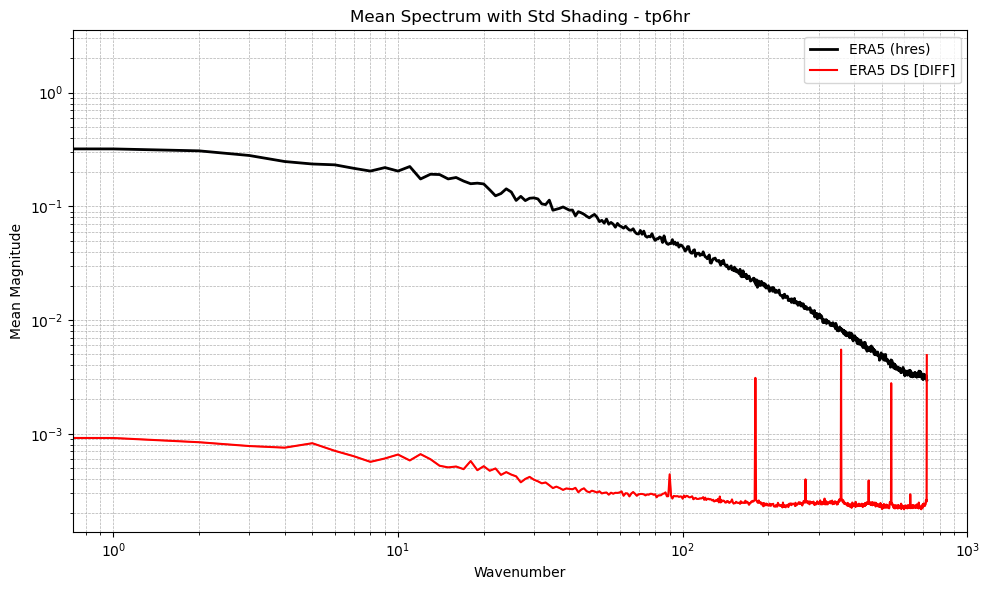

In [44]:

hres_spectrum = compute_spectrum_torch(torch.tensor(hres_denorm[1]).unsqueeze(0))
output_spectrum = compute_spectrum_torch(torch.tensor(output_denorm[1]).unsqueeze(0))

hres_spectrum_mean = hres_spectrum.mean(axis=1).mean(axis=0)
hres_spectrum_std = hres_spectrum.mean(axis=1).std(axis=0)

output_spectrum_mean = output_spectrum.mean(axis=1).mean(axis=0)
output_spectrum_std = output_spectrum.mean(axis=1).std(axis=0)

# Wavenumbers
longitude_points = hres_denorm[1].shape[-1]
wavenumbers = np.arange(0, longitude_points // 2 + 1)

# Plotting the spectra
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting High-Resolution Spectrum
plt.loglog(wavenumbers, hres_spectrum_mean, label="ERA5 (hres)", color="black", linewidth=2)
plt.fill_between(wavenumbers, hres_spectrum_mean - hres_spectrum_std, hres_spectrum_mean + hres_spectrum_std, color="blue", alpha=0.3)

# Plotting Model Output Spectrum
plt.loglog(wavenumbers, output_spectrum_mean, label="ERA5 DS [DIFF]", color="red")
plt.fill_between(wavenumbers, output_spectrum_mean - output_spectrum_std, output_spectrum_mean + output_spectrum_std, color="red", alpha=0.3)

# # Plotting Lucie Zero Shot Spectrum
# plt.loglog(wavenumbers, lucie_zero_shot_spectrum_mean, label="Lucie DS - Zero Shot", color="orange")
# plt.fill_between(wavenumbers, lucie_zero_shot_spectrum_mean - lucie_zero_shot_spectrum_std, lucie_zero_shot_spectrum_mean + lucie_zero_shot_spectrum_std, color="orange", alpha=0.3)

# # Plotting Low-Res Interpolated Spectrum
# plt.loglog(wavenumbers, lres_interp_spectrum_mean, label="ERA5 Interpolated", color="green")
# plt.fill_between(wavenumbers, lres_interp_spectrum_mean - lres_interp_spectrum_std, lres_interp_spectrum_mean + lres_interp_spectrum_std, color="green", alpha=0.3)

# # Plotting Lucie Interpolated Spectrum
# plt.loglog(wavenumbers, lucie_interp_spectrum_mean, label="Lucie Interpolated", color="purple")
# plt.fill_between(wavenumbers, lucie_interp_spectrum_mean - lucie_interp_spectrum_std, lucie_interp_spectrum_mean + lucie_interp_spectrum_std, color="purple", alpha=0.3)


plt.title("Mean Spectrum with Std Shading - tp6hr")
plt.xlabel("Wavenumber")
plt.ylabel("Mean Magnitude")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

(721,)


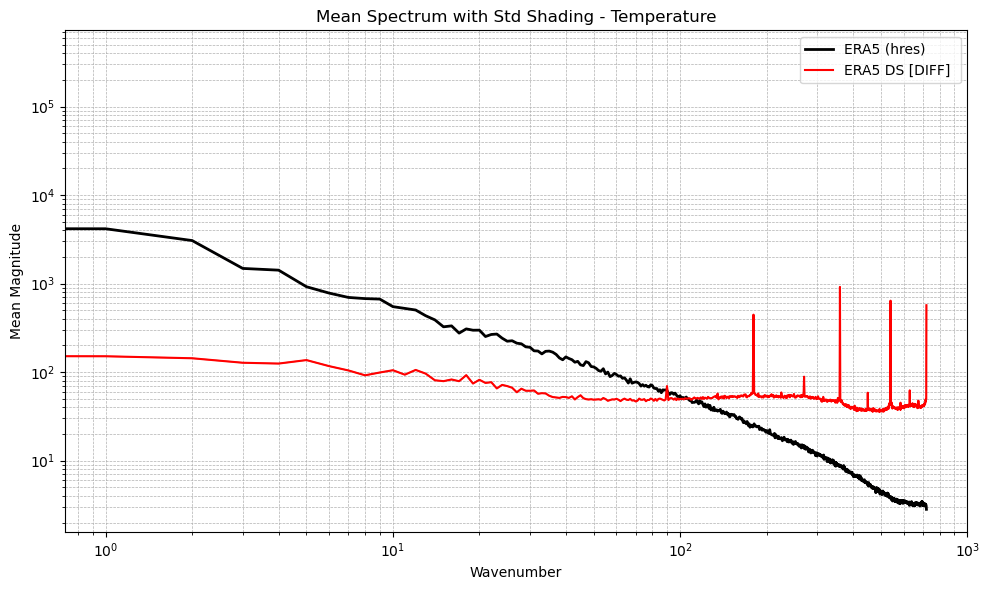

In [45]:
# Compute the spectra
# hres_spectrum = compute_spectrum_torch(hres_temperature_denorm)
# output_spectrum = compute_spectrum_torch(output_temperature_denorm)
# lres_interp_spectrum = compute_spectrum_torch(lres_interp_temperature_denorm)
# lucie_spectrum = compute_spectrum_torch(lucie_temperature)
# lucie_interp_spectrum = compute_spectrum_torch(lucie_interp_temperature)
# lucie_zero_shot_spectrum = compute_spectrum_torch(lucie_zero_shot_temperature)

hres_spectrum = compute_spectrum_torch(torch.tensor(hres_denorm[0]).unsqueeze(0))
output_spectrum = compute_spectrum_torch(torch.tensor(output_denorm[0]).unsqueeze(0))
# lres_interp_spectrum = compute_spectrum_torch(torch.tensor(lres_interp_denorm[0]).unsqueeze(0))
# lucie_spectrum = compute_spectrum_torch(torch.tensor(lucie_denorm[0]).unsqueeze(0))
# lucie_interp_spectrum = compute_spectrum_torch(torch.tensor(lucie_interp_denorm[0]).unsqueeze(0))
# lucie_zero_shot_spectrum = compute_spectrum_torch(torch.tensor(lucie_zero_shot_denorm[0]).unsqueeze(0))
                                                  
hres_spectrum_mean = hres_spectrum.mean(axis=1).mean(axis=0)
hres_spectrum_std = hres_spectrum.mean(axis=1).std(axis=0)

output_spectrum_mean = output_spectrum.mean(axis=1).mean(axis=0)
output_spectrum_std = output_spectrum.mean(axis=1).std(axis=0)

# lres_interp_spectrum_mean = lres_interp_spectrum.mean(axis=1).mean(axis=0)
# lres_interp_spectrum_std = lres_interp_spectrum.mean(axis=1).std(axis=0)

# lucie_spectrum_mean = lucie_spectrum.mean(axis=1).mean(axis=0)
# lucie_spectrum_std = lucie_spectrum.mean(axis=1).std(axis=0)

# lucie_interp_spectrum_mean = lucie_interp_spectrum.mean(axis=1).mean(axis=0)
# lucie_interp_spectrum_std = lucie_interp_spectrum.mean(axis=1).std(axis=0)

# lucie_zero_shot_spectrum_mean = lucie_zero_shot_spectrum.mean(axis=1).mean(axis=0)
# lucie_zero_shot_spectrum_std = lucie_zero_shot_spectrum.mean(axis=1).std(axis=0)

# Wavenumbers
longitude_points = hres_denorm.shape[-1]
wavenumbers = np.arange(0, longitude_points // 2 + 1)

print(wavenumbers.shape)

# Plotting the spectra
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting High-Resolution Spectrum
plt.loglog(wavenumbers, hres_spectrum_mean, label="ERA5 (hres)", color="black", linewidth=2)
plt.fill_between(wavenumbers, hres_spectrum_mean - hres_spectrum_std, hres_spectrum_mean + hres_spectrum_std, color="blue", alpha=0.3)

# Plotting Model Output Spectrum
plt.loglog(wavenumbers, output_spectrum_mean, label="ERA5 DS [DIFF] ", color="red")
plt.fill_between(wavenumbers, output_spectrum_mean - output_spectrum_std, output_spectrum_mean + output_spectrum_std, color="red", alpha=0.3)

# # Plotting Lucie Zero Shot Spectrum
# plt.loglog(wavenumbers, lucie_zero_shot_spectrum_mean, label="Lucie DS - Zero Shot", color="blue")
# plt.fill_between(wavenumbers, lucie_zero_shot_spectrum_mean - lucie_zero_shot_spectrum_std, lucie_zero_shot_spectrum_mean + lucie_zero_shot_spectrum_std, color="black", alpha=0.3)

# # Plotting Low-Res Interpolated Spectrum
# plt.loglog(wavenumbers, lres_interp_spectrum_mean, label="ERA5 Interpolated", color="green")
# plt.fill_between(wavenumbers, lres_interp_spectrum_mean - lres_interp_spectrum_std, lres_interp_spectrum_mean + lres_interp_spectrum_std, color="green", alpha=0.3)

# Plotting Lucie Spectrum
# plt.loglog(wavenumbers, lucie_spectrum_mean, label="Lucie", color="purple")
# plt.fill_between(wavenumbers, lucie_spectrum_mean - lucie_spectrum_std, lucie_spectrum_mean + lucie_spectrum_std, color="purple", alpha=0.3)

# # Plotting Lucie Interpolated Spectrum
# plt.loglog(wavenumbers, lucie_interp_spectrum_mean, label="Lucie Interpolated", color="orange")
# plt.fill_between(wavenumbers, lucie_interp_spectrum_mean - lucie_interp_spectrum_std, lucie_interp_spectrum_mean + lucie_interp_spectrum_std, color="orange", alpha=0.3)


plt.title("Mean Spectrum with Std Shading - Temperature")
plt.xlabel("Wavenumber")
plt.ylabel("Mean Magnitude")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()